In [268]:
import pandas as pd
import io
import os
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import hilbert
from scipy.stats import skew, kurtosis
import mplfinance as mpf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import kaleido
import talib



In [269]:
df_1hr = pd.read_csv('btcusdt_1h_train.csv')
df_1hr.rename(columns={'datetime': 'Date'}, inplace=True)
df_1hr['Date'] = pd.to_datetime(df_1hr['Date'])
df_1hr.set_index('Date', inplace=True)

In [270]:
df_5min = pd.read_csv('btcusdt_5m_train.csv')
df_5min.rename(columns={'datetime': 'Date'}, inplace=True)
df_5min['Date'] = pd.to_datetime(df_5min['Date'])
df_5min.set_index('Date', inplace=True)



In [271]:
df_5min = df_5min.drop('Unnamed: 0', axis=1) 


In [272]:
df_5min
col_req=df_5min.columns



In [273]:


# Now perform the resampling
df_daily = df_5min.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Reset the index if you want 'Date' back as a column
df_daily.reset_index(inplace=True)

In [274]:
df_daily

,Date,open,high,low,close,volume
0,2018-01-01,13715.65,13818.55,12750.00,13180.09,6871.114234
1,2018-01-02,13180.18,14388.88,12890.02,14370.00,15566.357977
2,2018-01-03,14370.02,15473.49,14150.00,14793.46,20140.904101
3,2018-01-04,14768.55,15280.00,13918.04,14744.99,18641.888012
4,2018-01-05,14744.99,17118.13,14600.00,16871.03,22230.508702
...,...,...,...,...,...,...
1243,2021-05-28,38965.12,39222.13,35100.00,35885.80,120433.899296
1244,2021-05-29,35895.23,37338.58,33632.76,33823.07,121092.055667
1245,2021-05-30,33822.10,36488.00,33379.00,36103.59,83210.803052
1246,2021-05-31,36103.60,37457.07,34153.84,36758.45,94138.691101


In [275]:
# df_daily.to_csv('daily.csv', index=False)
scaler = MinMaxScaler()

df_5min['OC/V_normalized'] = scaler.fit_transform(df_5min[['OC/V']])


KeyError: "None of [Index(['OC/V'], dtype='object')] are in the [columns]"

## VWAP

#### VWAP, or Volume Weighted Average Price, is a trading benchmark used primarily in stock trading. It represents the average price a security has traded at throughout the day, based on both volume and price. It is a measure of the average price at which a stock is traded over the trading horizon.

#### VWAP is calculated by adding up the dollar amount traded for every transaction (price multiplied by the number of shares traded) and then dividing by the total shares traded. 

In [ ]:
# Calculate Typical Price
df_5min['Typical_Price'] = (df_5min['high'] + df_5min['low'] + df_5min['close']) / 3

# Calculate Typical Price * Volume
df_5min['TP_Volume'] = df_5min['Typical_Price'] * df_5min['volume']

# Calculate Cumulative Total of Typical Price * Volume and Cumulative Total Volume
df_5min['Cumulative_TP_Volume'] = df_5min['TP_Volume'].rolling(window=500).sum()
df_5min['Cumulative_Volume'] = df_5min['volume'].rolling(window=500).sum()

# Calculate VWAP
df_5min['VWAP'] = df_5min['Cumulative_TP_Volume'] / df_5min['Cumulative_Volume']

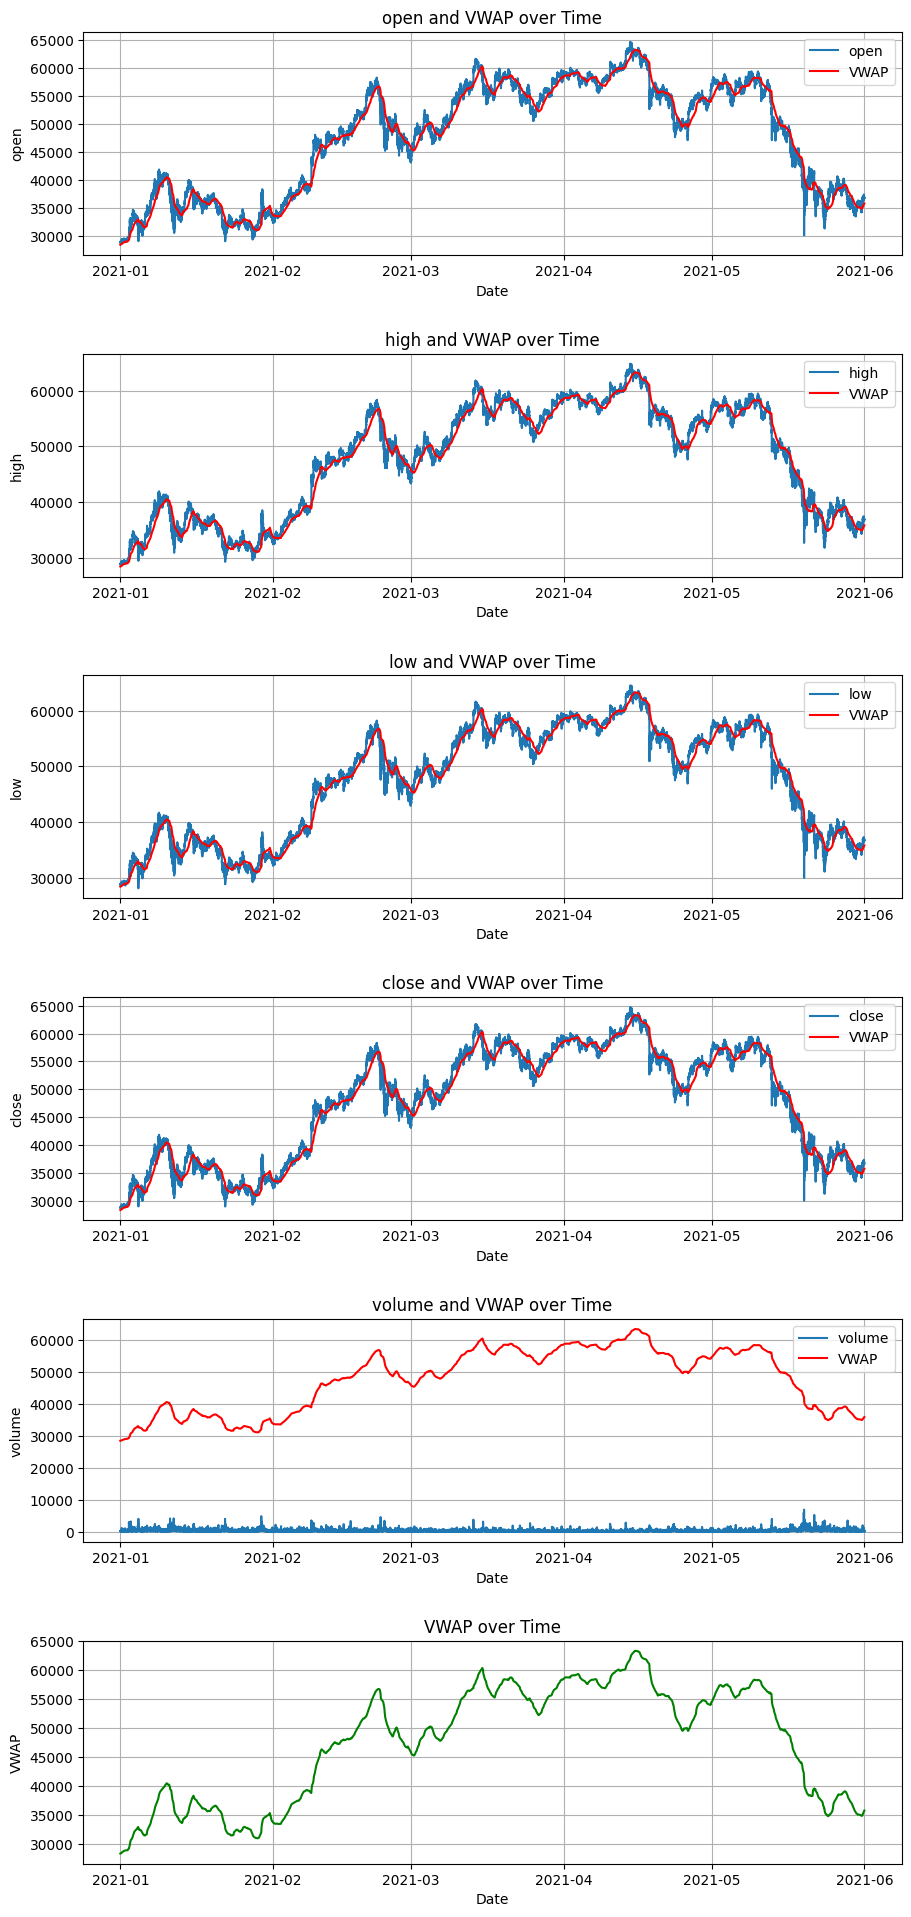

In [ ]:
df_2020_onwards = df_5min[df_5min.index.year >= 2021]

# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and VWAP in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_2020_onwards.index, (df_2020_onwards[[col]]), label=col)
    axes[i].plot(df_2020_onwards.index,(df_2020_onwards[['VWAP']]), label='VWAP', color='red')
    axes[i].set_title(f'{col} and VWAP over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting VWAP in the 6th subplot
axes[5].plot(df_2020_onwards.index, df_2020_onwards['VWAP'], label='VWAP', color='green')
axes[5].set_title('VWAP over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('VWAP')
axes[5].grid(True)

plt.show()

In [ ]:
correlation_matrix = df_5min[['open', 'high', 'low', 'close', 'volume', 'VWAP']].corr()

# Print the correlation matrix
print(correlation_matrix)


            open      high       low     close    volume      VWAP
open    1.000000  0.999994  0.999993  0.999990  0.175864  0.780721
high    0.999994  1.000000  0.999988  0.999994  0.177018  0.781016
low     0.999993  0.999988  1.000000  0.999994  0.174425  0.780434
close   0.999990  0.999994  0.999994  1.000000  0.175746  0.780707
volume  0.175864  0.177018  0.174425  0.175746  1.000000  0.107874
VWAP    0.780721  0.781016  0.780434  0.780707  0.107874  1.000000


## Spread (O-C)

In [ ]:
df_5min['OC_Spread']=df_5min['open']-df_5min['close']
df_5min['OC_Spread_abs']=abs(df_5min['OC_Spread'])

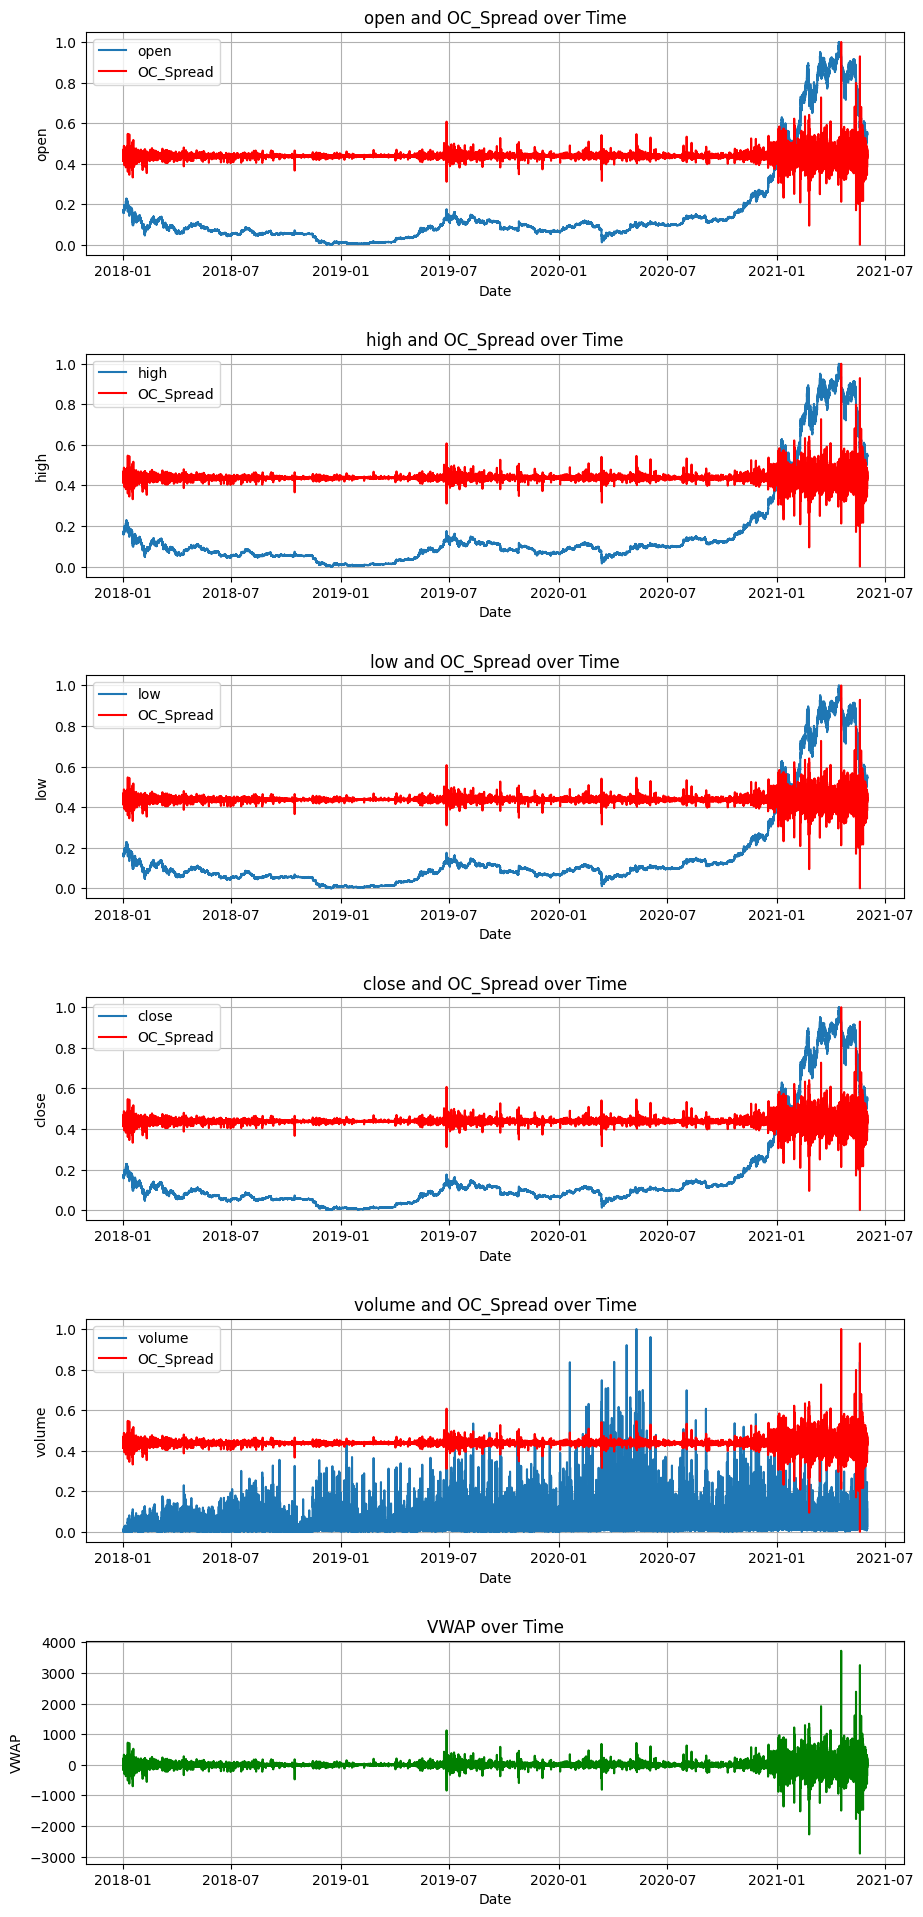

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and VWAP in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_5min.index, scaler.fit_transform(df_5min[[col]]), label=col)
    axes[i].plot(df_5min.index, scaler.fit_transform(df_5min[['OC_Spread']]), label='OC_Spread', color='red')
    axes[i].set_title(f'{col} and OC_Spread over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting VWAP in the 6th subplot
axes[5].plot(df_5min.index, df_5min['OC_Spread'], label='VWAP', color='green')
axes[5].set_title('VWAP over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('VWAP')
axes[5].grid(True)

plt.show()

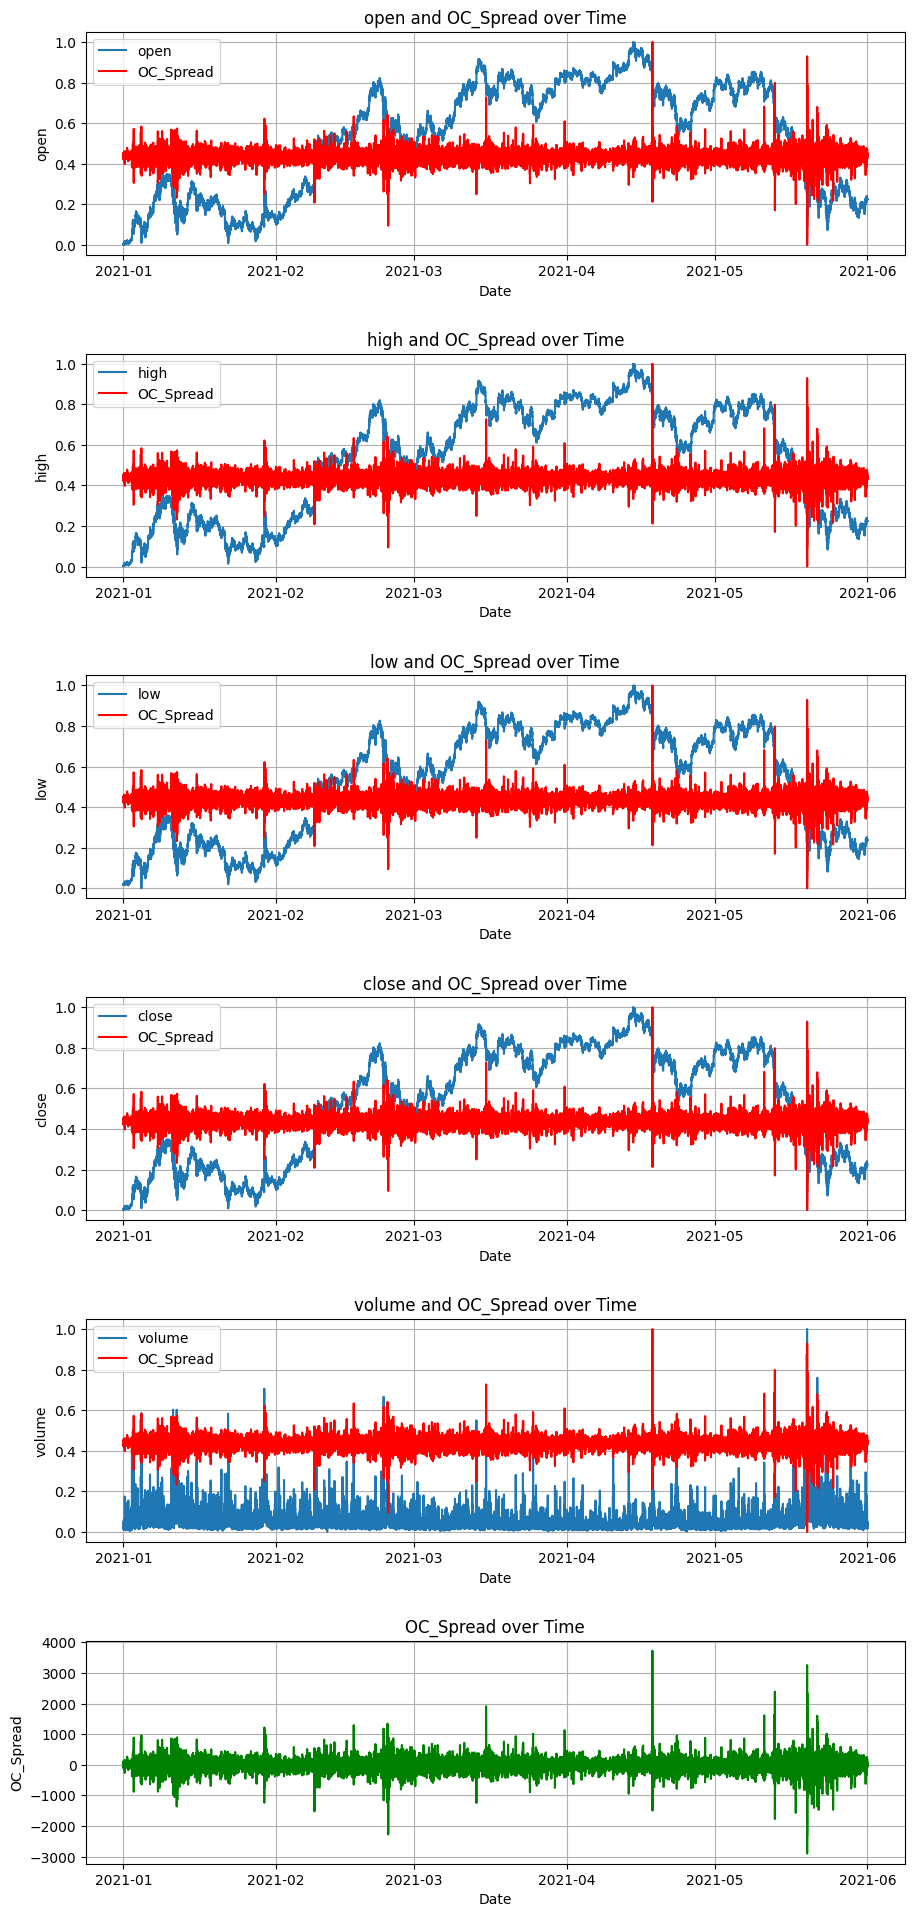

In [ ]:

df_2021_onwards = df_5min[df_5min.index.year >= 2021]

# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and OC_Spread in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_2021_onwards.index, scaler.fit_transform(df_2021_onwards[[col]]), label=col)
    axes[i].plot(df_2021_onwards.index, scaler.fit_transform(df_2021_onwards[['OC_Spread']]), label='OC_Spread', color='red')
    axes[i].set_title(f'{col} and OC_Spread over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting OC_Spread in the 6th subplot
axes[5].plot(df_2021_onwards.index, df_2021_onwards['OC_Spread'], label='OC_Spread', color='green')
axes[5].set_title('OC_Spread over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('OC_Spread')
axes[5].grid(True)

plt.show()


In [ ]:
correlation_matrix_ocs = df_5min[['open', 'high', 'low', 'close', 'volume', 'VWAP','OC_Spread']].corr()

# Print the correlation matrix
print(correlation_matrix_ocs)

               open      high       low     close    volume      VWAP  \
open       1.000000  0.999994  0.999993  0.999990  0.175864  0.780721   
high       0.999994  1.000000  0.999988  0.999994  0.177018  0.781016   
low        0.999993  0.999988  1.000000  0.999994  0.174425  0.780434   
close      0.999990  0.999994  0.999994  1.000000  0.175746  0.780707   
volume     0.175864  0.177018  0.174425  0.175746  1.000000  0.107874   
VWAP       0.780721  0.781016  0.780434  0.780707  0.107874  1.000000   
OC_Spread  0.001198 -0.001060 -0.001214 -0.003206  0.026748  0.002413   

           OC_Spread  
open        0.001198  
high       -0.001060  
low        -0.001214  
close      -0.003206  
volume      0.026748  
VWAP        0.002413  
OC_Spread   1.000000  


### Volume Weighted Spread

In [ ]:
# Calculate Typical Price * Volume
df_5min['OC_Volume'] = df_5min['OC_Spread'] * df_5min['volume']

# Calculate Cumulative Total of Typical Price * Volume and Cumulative Total Volume
df_5min['Cumulative_OC_Volume'] = df_5min['OC_Volume'].cumsum()
# Calculate VWAP
df_5min['VWOC'] = df_5min['Cumulative_OC_Volume'] / df_5min['Cumulative_Volume']

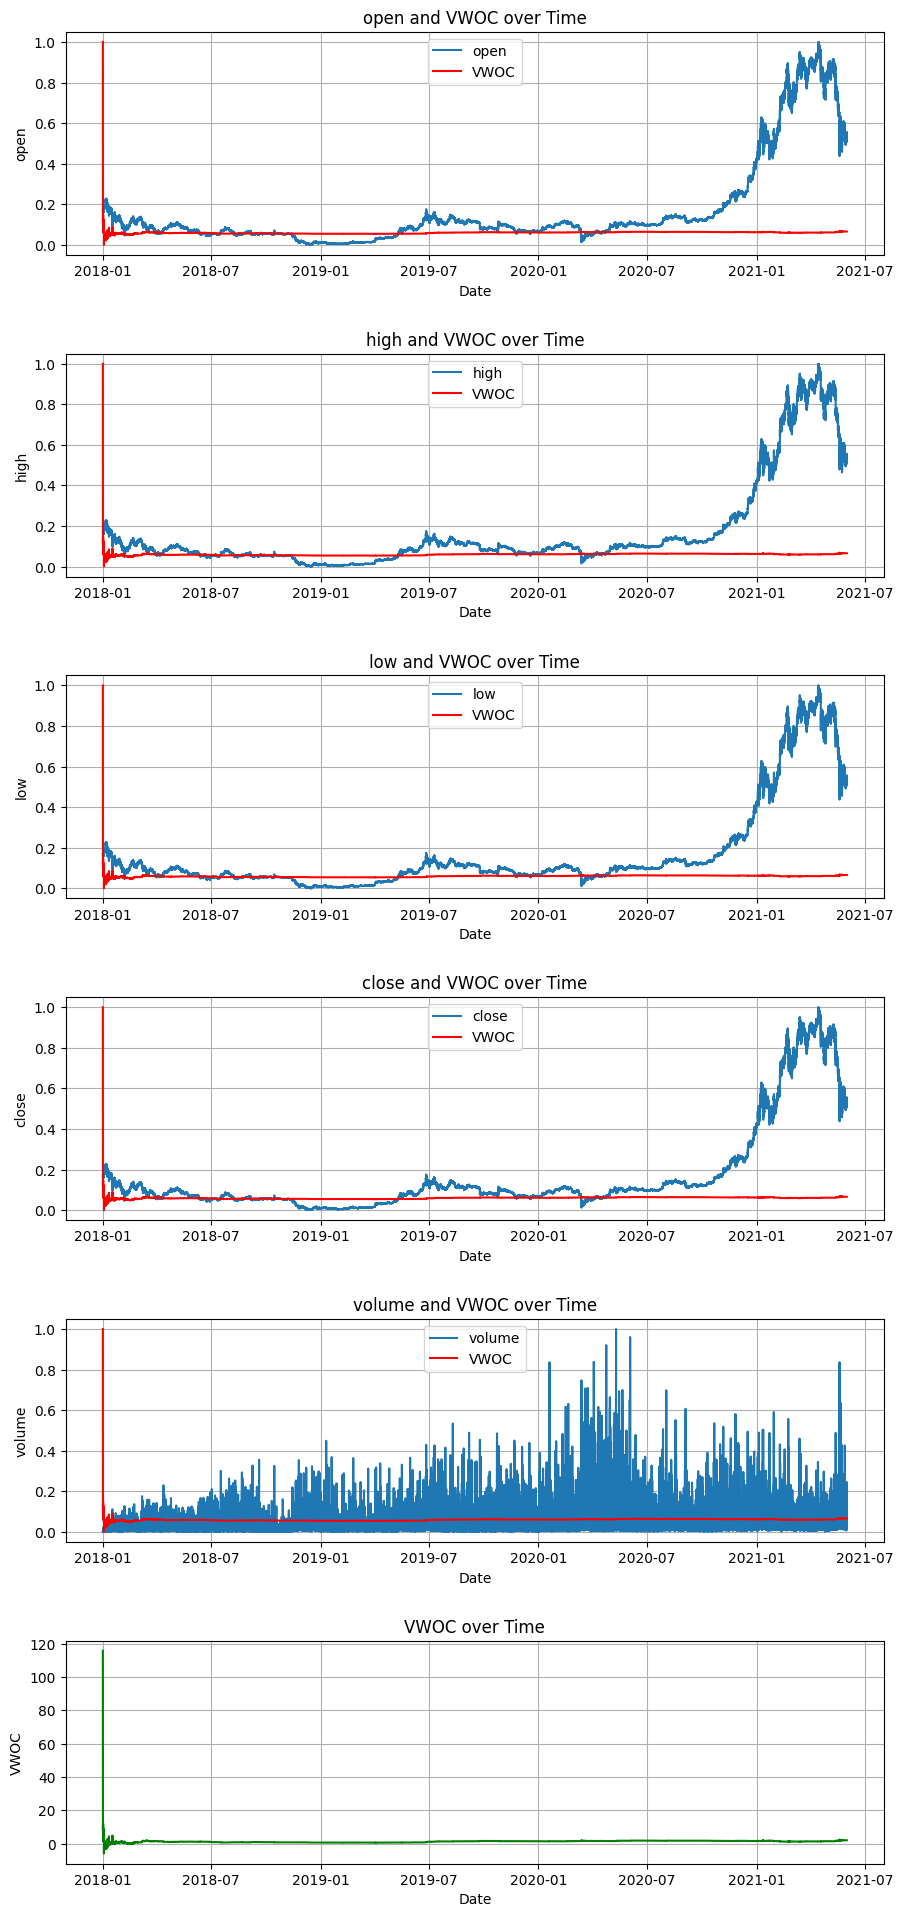

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and VWAP in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_5min.index, scaler.fit_transform(df_5min[[col]]), label=col)
    axes[i].plot(df_5min.index, scaler.fit_transform(df_5min[['VWOC']]), label='VWOC', color='red')
    axes[i].set_title(f'{col} and VWOC over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting VWAP in the 6th subplot
axes[5].plot(df_5min.index, df_5min['VWOC'], label='VWOC', color='green')
axes[5].set_title('VWOC over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('VWOC')
axes[5].grid(True)

plt.show()

In [ ]:
correlation_matrix_vwocs = df_5min[['open', 'high', 'low', 'close', 'volume', 'VWAP','OC_Spread','VWOC','OC_Volume']].corr()
print(correlation_matrix_vwocs)

               open      high       low     close    volume      VWAP  \
open       1.000000  0.999994  0.999993  0.999990  0.175864  0.780721   
high       0.999994  1.000000  0.999988  0.999994  0.177018  0.781016   
low        0.999993  0.999988  1.000000  0.999994  0.174425  0.780434   
close      0.999990  0.999994  0.999994  1.000000  0.175746  0.780707   
volume     0.175864  0.177018  0.174425  0.175746  1.000000  0.107874   
VWAP       0.780721  0.781016  0.780434  0.780707  0.107874  1.000000   
OC_Spread  0.001198 -0.001060 -0.001214 -0.003206  0.026748  0.002413   
VWOC       0.187244  0.187202  0.187270  0.187215  0.151263  0.047158   
OC_Volume  0.004443  0.003130  0.002741  0.001624  0.064560  0.003894   

           OC_Spread      VWOC  OC_Volume  
open        0.001198  0.187244   0.004443  
high       -0.001060  0.187202   0.003130  
low        -0.001214  0.187270   0.002741  
close      -0.003206  0.187215   0.001624  
volume      0.026748  0.151263   0.064560  
VWAP 

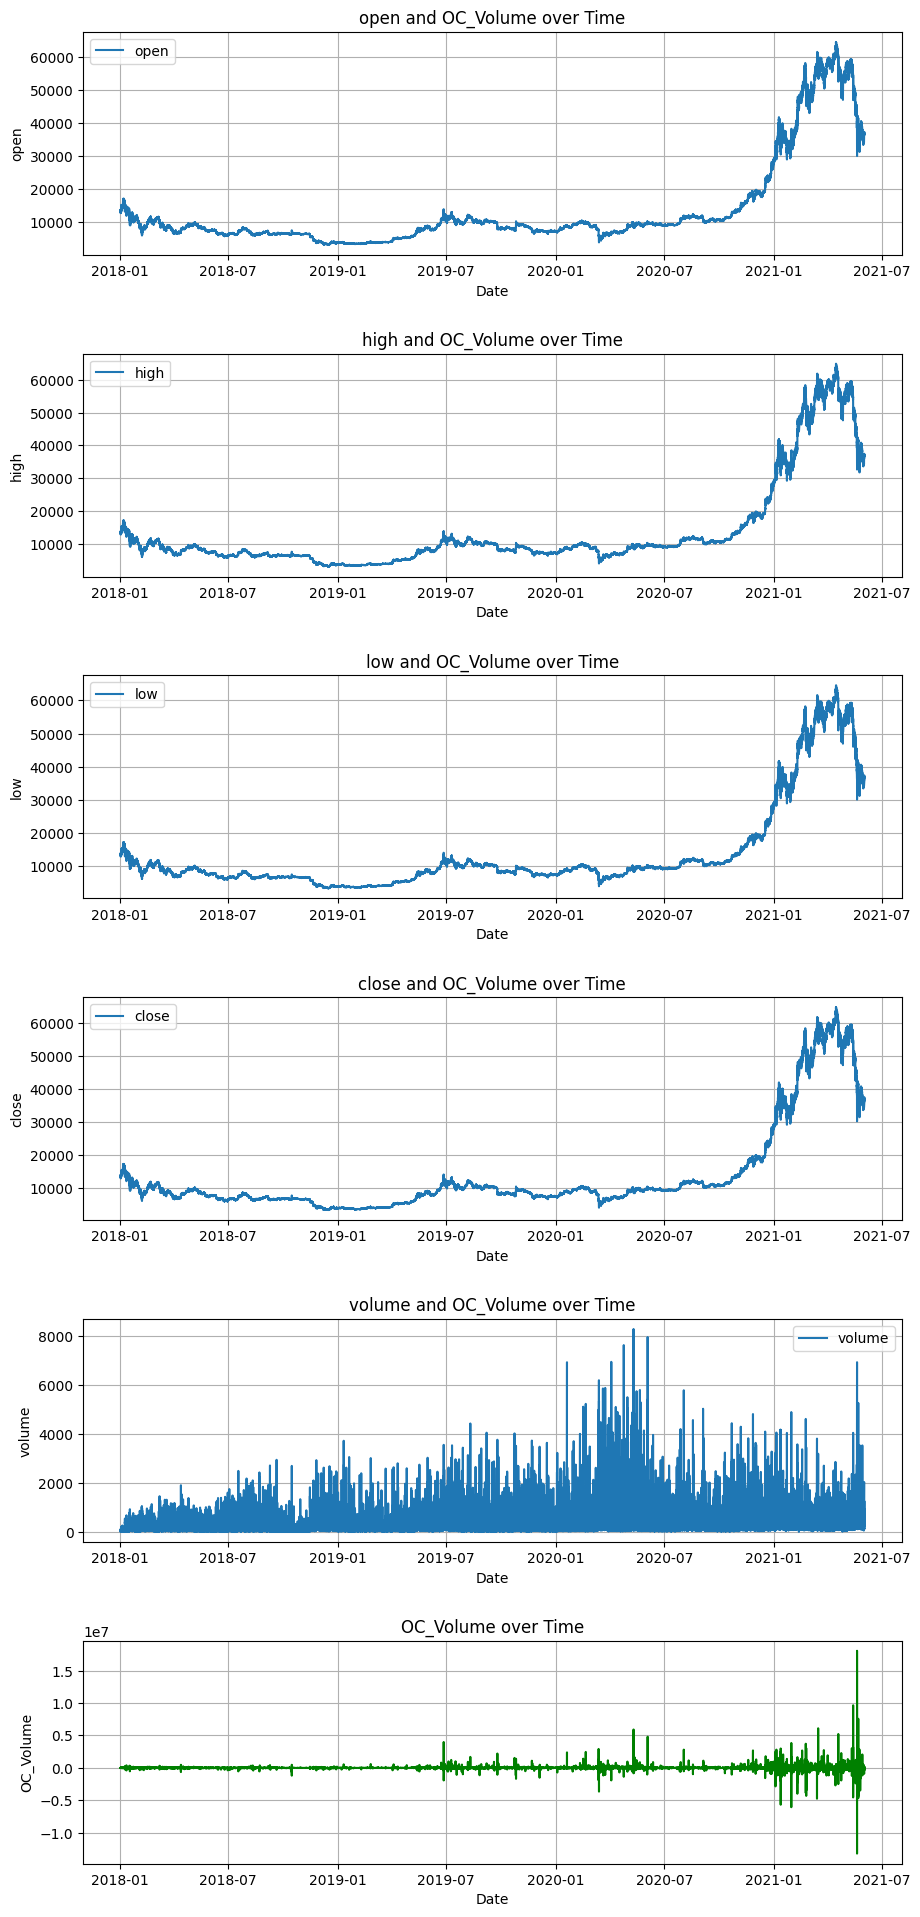

In [ ]:
# Calculate Typical Price * Volume
df_5min['OC_Volume'] = df_5min['OC_Spread'] * df_5min['volume']

# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and VWAP in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_5min.index, df_5min[col], label=col)
    # axes[i].plot(df_5min.index, df_5min['OC_Volume'], label='OC_Volume', color='red')
    axes[i].set_title(f'{col} and OC_Volume over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting VWAP in the 6th subplot
axes[5].plot(df_5min.index, df_5min['OC_Volume'], label='OC_Volume', color='green')
axes[5].set_title('OC_Volume over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('OC_Volume')
axes[5].grid(True)

plt.show()

### Volume Spread 
VS= V(t)-V(t-1)


In [ ]:
df_5min['VS'] = df_5min['volume'].diff()


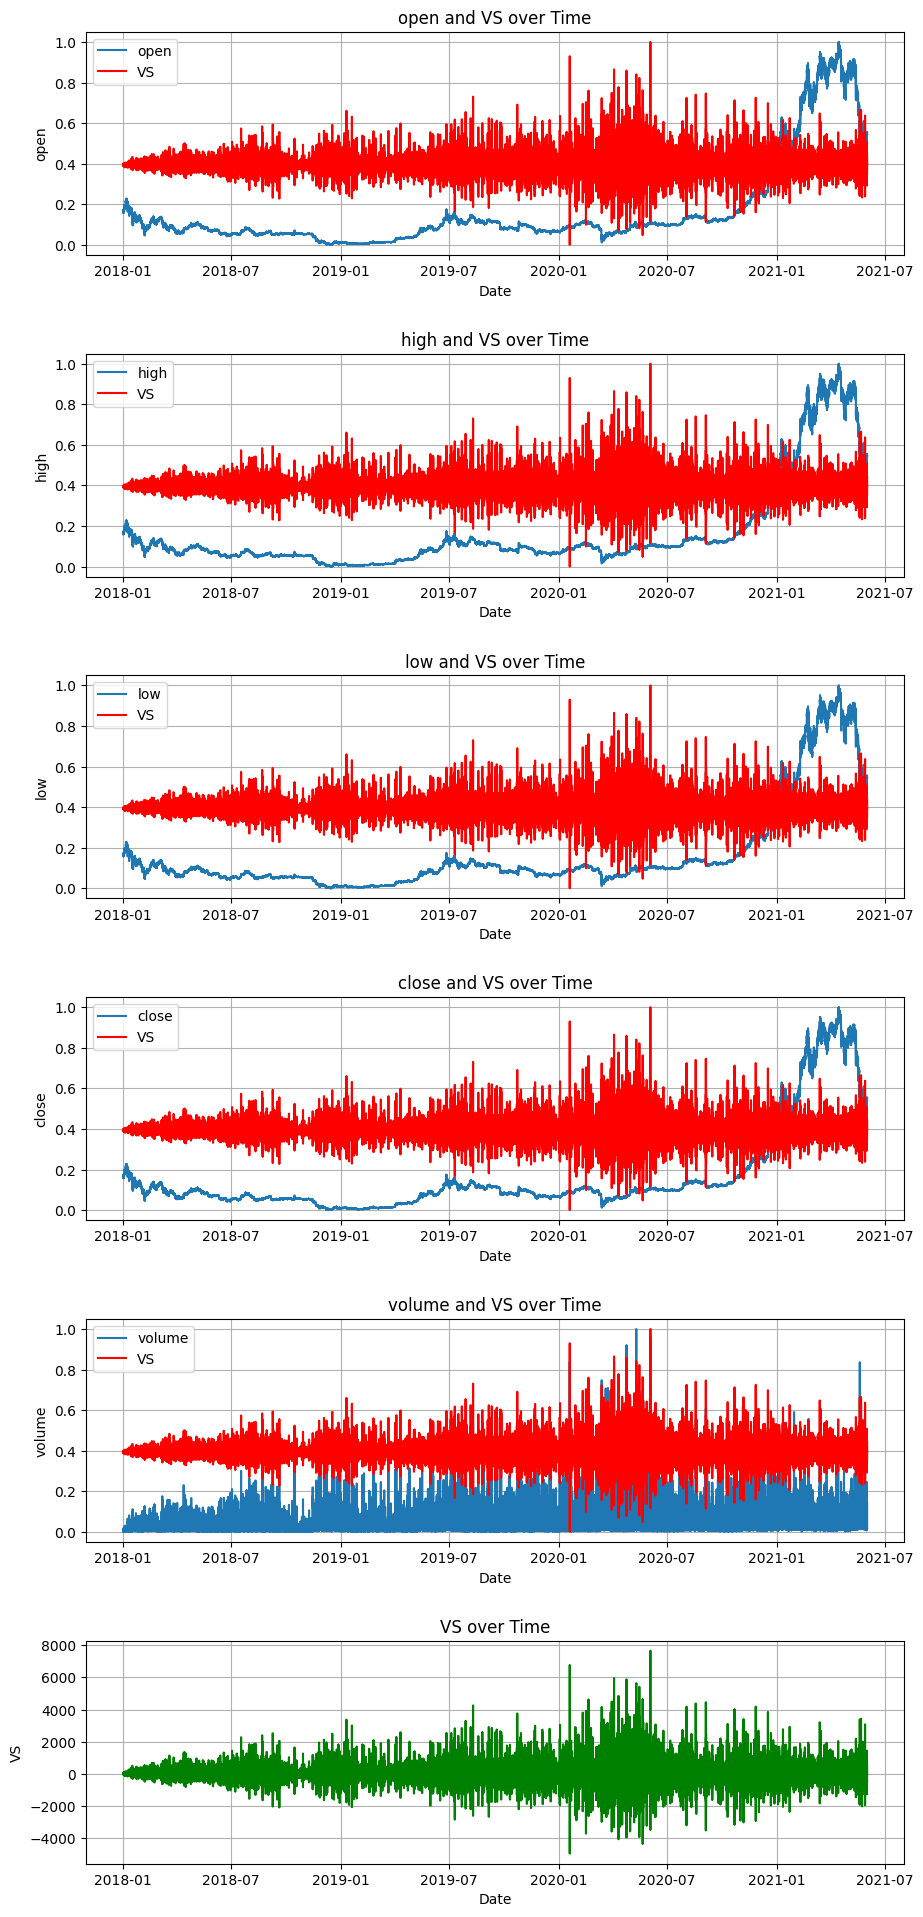

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and VWAP in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_5min.index, scaler.fit_transform(df_5min[[col]]), label=col)
    axes[i].plot(df_5min.index, scaler.fit_transform(df_5min[['VS']]), label='VS', color='red')
    axes[i].set_title(f'{col} and VS over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting VWAP in the 6th subplot
axes[5].plot(df_5min.index, df_5min['VS'], label='VS', color='green')
axes[5].set_title('VS over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('VS')
axes[5].grid(True)

plt.show()

In [ ]:
correlation_matrix = df_5min[['open', 'high', 'low', 'close', 'volume', 'VWAP','OC_Spread','VWOC','OC_Volume','VS','VS_7days']].corr()
print(correlation_matrix)

KeyError: "['VS_7days'] not in index"

In [ ]:
periods_for_7_days = 288 * 7  # 288 periods per day for 7 days

# Calculate the rolling sum for the volume over 7 days
df_5min['VS_7days'] = df_5min['volume'].rolling(window=periods_for_7_days).sum()

# Calculate the difference between the current and previous 7-day rolling sum
df_5min['VS_7days'] = df_5min['VS_7days'].diff()

# Display the DataFrame to verify the calculation


In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and VWAP in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_5min.index, df_5min[col], label=col)
    axes[i].plot(df_5min.index, df_5min['VS_7days'], label='VS_7days', color='red')
    axes[i].set_title(f'{col} and VS_7days over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting VWAP in the 6th subplot
axes[5].plot(df_5min.index, df_5min['VS_7days'], label='VS_7days', color='green')
axes[5].set_title('VS_7days over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('VS_7days')
axes[5].grid(True)

plt.show()

In [ ]:
df_5min

In [ ]:
cols=['VWAP','OC_Spread','OC_Spread_abs','OC_Volume','Cumulative_OC_Volume','VWOC','VS','VS_7days']

In [ ]:
cols = ['VWAP', 'OC_Spread', 'OC_Spread_abs', 'OC_Volume', 'Cumulative_OC_Volume', 'VWOC', 'VS', 'VS_7days']
for col in cols:
    df_5min[f'exp_{col}'] = np.exp(-df_5min[col])
    df_5min[f'log_{col}'] = np.log(df_5min[col].replace(0, np.nan))

# Prepare the list of columns for the correlation matrix
corr_cols = ['open', 'high', 'low', 'close', 'volume', 'VWAP', 'OC_Spread', 'VWOC', 'OC_Volume', 'VS', 'VS_7days'] + \
            [f'exp_{col}' for col in cols] + [f'log_{col}' for col in cols]

# Calculate the correlation matrix
correlation_matrix = df_5min[corr_cols].corr()

# Print the correlation matrix
print(correlation_matrix)

In [ ]:
max_lags = 17  # Specify the maximum number of lags you want to test
test_result = sm.tsa.stattools.grangercausalitytests(df_5min[['close', 'log_VWAP']], max_lags, verbose=True)


In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and VWAP in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_5min.index, scaler.fit_transform(df_5min[[col]]), label=col)
    axes[i].plot(df_5min.index, scaler.fit_transform(df_5min[['log_OC_Spread']]), label='log_OC_Spread', color='red')
    axes[i].set_title(f'{col} and log_OC_Spread over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting VWAP in the 6th subplot
axes[5].plot(df_5min.index, df_5min['log_OC_Spread'], label='log_OC_Spread', color='green')
axes[5].set_title('log_OC_Spread over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('log_OC_Spread')
axes[5].grid(True)

plt.show()

In [ ]:
plt.plot(df_5min.index, df_5min[''], label=col)


In [ ]:
plt.plot(df_5min.index, df_5min['log_'], label=col)
plt.plot(df_5min.index, np.log(df_5min['close']), label=col)

In [ ]:
import pandas as pd
import numpy as np
# Load data from the CSV file
file_path = "btcusdt_15m_train.csv"
log = pd.read_csv(file_path)

# Print column names for reference
print("Column Names:", log.columns)

# Modified function to use your data
def calculate_log_vwap(df_5min, column='close'):
    if column not in df_5min.columns:
        raise KeyError(f"Column '{column}' not found in the DataFrame.")
    tp = (df_5min['high'] + df_5min['low'] + df_5min['close']) / 3
    tp_vol = tp* df_5min['volume']
    cum_tp_vol = tp_vol.cumsum()
    cum_vol = df_5min['volume'].cumsum()

    return np.log(cum_tp_vol/cum_vol)


def log_wvap_crossover(data):
    # Use 'close' as the default column if 'close' is not present in the columns
    close_column = 'close' if 'close' in data.columns else data.columns[1]
    
    data['log_close'] = np.log(data['close'])
    data['log_vwap'] = calculate_log_vwap(data)
    data['indicator'] = 0

    # Calculate indicator based on EMA crossover
    data.loc[data['log_close'] < data['log_vwap'], 'indicator'] = 1
    data.loc[data['log_close'] > data['log_vwap'], 'indicator'] = -1

    last_signal = 0
    for index, _ in data.iterrows():
        data.at[index, 'signal'] = 0
        if data.at[index, 'indicator'] == 1:
            if last_signal == 0 or last_signal == -1:
                # enter long position
                last_signal = 1
                data.at[index, 'signal'] = 1
        elif data.at[index, 'indicator'] == -1:
            if last_signal == 1:
                # exit long position
                last_signal = -1
                data.at[index, 'signal'] = -1
    
    # Remove consecutive signals, keep only when there's a change
    data['signal'] = data['signal'].where(data['signal'] != data['signal'].shift(), 0)
    
    return data

# Apply EMA crossover strategy
log = log_wvap_crossover(log)
log = log.drop('Unnamed: 0', axis=1) 
log.set_index('datetime', inplace=True)

# Save to CSV
log.to_csv("log.csv", index=True)


In [ ]:
log

In [ ]:
df_5min

In [ ]:
df_5min['close_change']=df_5min['close'].diff(-1)
df_5min['open_change']=df_5min['open'].diff(-1)
df_5min['low_change']=df_5min['low'].diff(-1)
df_5min['high_change']=df_5min['high'].diff(-1)
df_5min['volume_change']=df_5min['volume'].diff(-1)

In [ ]:
df_5min.head

In [ ]:
correlation = df_5min['log_VWAP'].corr(df_5min['close_change'])

print("Correlation: ", correlation)

In [ ]:
correlation_matrix = df_5min.corr()

In [ ]:
ohlcv_columns = ['close_change', 'volume_change']  # Replace with your OHLCV column names
indicators = ['VWAP','OC_Spread','VWOC','OC_Volume','VS','VS_7days','log_VWAP', 'log_OC_Spread', 'log_OC_Spread_abs', 'log_OC_Volume', 'log_Cumulative_OC_Volume', 'log_VWOC', 'log_VS_7days','log_VS']  # Replace with your indicator names

# Print the correlations
for indicator in indicators:
    print(f"Correlations for {indicator}:")
    for ohlcv in ohlcv_columns:
        print(f"{indicator} and {ohlcv}: {correlation_matrix.loc[indicator, ohlcv]}")
    print()

In [ ]:
#VWAP last 10 days
## Add a decay of time to 
## Inverse volume and volume weighted aveg check kar

In [ ]:
df_5min

In [ ]:
df_5min['TP_Volume']


## New

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plotting OHLCV and VWAP in first 5 subplots
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']
for i, col in enumerate(ohlcv_columns):
    axes[i].plot(df_5min.index, df_5min[col], label=col)
    axes[i].plot(df_5min.index, df_5min[f'VWAP_{lookback_periods}'], label=f'VWAP_{lookback_periods}', color='red')
    axes[i].set_title(f'{col} and VWAP over {lookback_periods}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Plotting VWAP in the 6th subplot
axes[5].plot(df_5min.index, df_5min[f'VWAP_{lookback_periods}'], label=f'VWAP{lookback_periods}', color='green')
axes[5].set_title('VWAP over Time')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('VWAP')
axes[5].grid(True)

plt.show()

In [ ]:
start_date = '2021-01-01'
end_date = '2021-01-2'

# Filter data for this period
filtered_data = df_5min[start_date:end_date]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['close'], label='Close Price', color='blue')
plt.plot(filtered_data[f'VWAP_{lookback_periods}'], label=f'VWAP {lookback_periods} periods', color='orange')

plt.title(f'Close Price and VWAP {lookback_periods} Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Apply a rolling window for 10 periods and calculate the VWAP
lookback_periods = 100
df_5min[f'VWAP_{lookback_periods}'] = df_5min['TP_Volume'].rolling(window=lookback_periods).sum() / df_5min['volume'].rolling(window=lookback_periods).sum()

df_cleaned = df_5min.dropna(subset=[f'VWAP_{lookback_periods}', 'close_change'])

tau, p_value = kendalltau(df_cleaned[f'VWAP_{lookback_periods}'], df_cleaned['close_change'])

print("Kendall's tau correlation:", tau)
print("P-value:", p_value)

In [ ]:
lookback_periods_list = [10, 20, 30, 50, 100, 150, 200,300,400,500,600,700]  # Example periods, adjust as needed

significant_correlations = {}  # Dictionary to store significant correlations

for lookback_periods in lookback_periods_list:
    # Calculate VWAP
    df_5min[f'VWAP_{lookback_periods}'] = df_5min['TP_Volume'].rolling(window=lookback_periods).sum() / df_5min['volume'].rolling(window=lookback_periods).sum()
    
    # Drop NaN values
    df_cleaned = df_5min.dropna(subset=[f'VWAP_{lookback_periods}', 'close_change'])

    # Calculate Kendall's tau correlation
    tau, p_value = kendalltau(df_cleaned[f'VWAP_{lookback_periods}'], df_cleaned['close_change'])

    # Check if the correlation is statistically significant (e.g., p-value < 0.05)
    if p_value < 0.05:
        significant_correlations[lookback_periods] = (tau, p_value)

# Print periods with statistically significant correlations
for period, values in significant_correlations.items():
    print(f"Lookback period: {period}, Kendall's tau: {values[0]}, P-value: {values[1]}")

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Assuming df_5min is your DataFrame
# df_5min = pd.read_csv('your_data.csv')  # Load your data

# Define the range of lookback periods you want to check
lookback_periods_list = [10, 20, 30, 50, 100, 150, 200]  # Example periods, adjust as needed

significant_correlations = {}  # Dictionary to store significant correlations

for lookback_periods in lookback_periods_list:
    # Calculate VWAP
    df_5min[f'VWAP_{lookback_periods}'] = df_5min['TP_Volume'].rolling(window=lookback_periods).sum() / df_5min['volume'].rolling(window=lookback_periods).sum()
    
    # Drop NaN values
    df_cleaned = df_5min.dropna(subset=[f'VWAP_{lookback_periods}', 'close_change'])

    # Calculate Spearman's rank correlation
    rho, p_value = spearmanr(df_cleaned[f'VWAP_{lookback_periods}'], df_cleaned['close_change'])

    # Check if the correlation is statistically significant (e.g., p-value < 0.05)
    if p_value < 0.05:
        significant_correlations[lookback_periods] = (rho, p_value)

# Print periods with statistically significant correlations
for period, values in significant_correlations.items():
    print(f"Lookback period: {period}, Spearman's rho: {values[0]}, P-value: {values[1]}")


In [ ]:
df_5min['OC_Volume_inv'] = df_5min['OC_Spread'] / df_5min['volume']
correlation_matrix = df_5min.corr()

In [ ]:
ohlcv_columns = ['close_change', 'volume_change']  # Replace with your OHLCV column names
indicators = ['OC_Volume_inv']  # Replace with your indicator names

# Print the correlations
for indicator in indicators:
    print(f"Correlations for {indicator}:")
    for ohlcv in ohlcv_columns:
        print(f"{indicator} and {ohlcv}: {correlation_matrix.loc[indicator, ohlcv]*100}")
    print()

In [ ]:
rsi_period = 5
rsi = talib.RSI(df_5min['close'].values, timeperiod=rsi_period)

# Add RSI to the DataFrame
df_5min['RSI'] = rsi

# Define a simple signal based on RSI
df_5min['Signal'] = 0
df_5min.loc[df_5min['RSI'] > 80, 'Signal'] = -1  # Overbought
df_5min.loc[df_5min['RSI'] < 25, 'Signal'] = 1 # Oversold

# Calculate future price movement (Close(t+1) - Close(t))
df_5min['Future Movement'] = df_5min['close'].shift(-1) - df_5min['close']

df_5min = df_5min.dropna()

# Correlation analysis
pearson_corr = df_5min[['Signal', 'Future Movement']].corr().iloc[0, 1]
kendall_corr = df_5min[['Signal', 'Future Movement']].corr(method='kendall').iloc[0, 1]
spearman_corr = df_5min[['Signal', 'Future Movement']].corr(method='spearman').iloc[0, 1]

# print("Correlation:", correlation*100)
print("Best Pearson Correlation:", pearson_corr*100)
print("Best Kendall Correlation:", kendall_corr*100)
print("Best Spearman Correlation:",spearman_corr*100)


In [ ]:


# Example ranges for parameter optimization
rsi_periods = range(5, 21)  # RSI periods from 5 to 20
upper_thresholds = range(60, 81, 5)  # Upper thresholds from 60 to 80, step of 5
lower_thresholds = range(20, 41, 5)  # Lower thresholds from 20 to 40, step of 5

best_pearson_corr = -1
best_kendall_corr = -1
best_spearman_corr = -1
best_params = {'pearson': {}, 'kendall': {}, 'spearman': {}}

for period in rsi_periods:
    rsi = talib.RSI(df_5min['close'].values, timeperiod=period)
    df_5min['RSI'] = rsi

    for upper in upper_thresholds:
        for lower in lower_thresholds:
            df_5min['Signal'] = 0
            df_5min.loc[df_5min['RSI'] > upper, 'Signal'] = 1
            df_5min.loc[df_5min['RSI'] < lower, 'Signal'] = -1

            # Calculate future price movement
            df_5min['Future Movement'] = df_5min['close'].shift(-1) - df_5min['close']

            # Drop NA values
            temp_df = df_5min.dropna()

            # Correlation analysis using Pearson, Kendall, and Spearman
            pearson_corr = abs(temp_df[['Signal', 'Future Movement']].corr(method='pearson').iloc[0, 1])
            kendall_corr = abs(temp_df[['Signal', 'Future Movement']].corr(method='kendall').iloc[0, 1])
            spearman_corr =abs(temp_df[['Signal', 'Future Movement']].corr(method='spearman').iloc[0, 1])

            # Update best parameters for Pearson correlation
            if pearson_corr > best_pearson_corr:
                best_pearson_corr = pearson_corr
                best_params['pearson'] = {'period': period, 'upper': upper, 'lower': lower}

            # Update best parameters for Kendall correlation
            if kendall_corr > best_kendall_corr:
                best_kendall_corr = kendall_corr
                best_params['kendall'] = {'period': period, 'upper': upper, 'lower': lower}

            # Update best parameters for Spearman correlation
            if spearman_corr > best_spearman_corr:
                best_spearman_corr = spearman_corr
                best_params['spearman'] = {'period': period, 'upper': upper, 'lower': lower}

print("Best Pearson Correlation:", best_pearson_corr)
print("Best Pearson Parameters:", best_params['pearson'])
print("Best Kendall Correlation:", best_kendall_corr)
print("Best Kendall Parameters:", best_params['kendall'])
print("Best Spearman Correlation:", best_spearman_corr)
print("Best Spearman Parameters:", best_params['spearman'])


In [ ]:
# Example ranges for parameter optimization
rsi_periods = range(5, 21)  # RSI periods from 5 to 20
upper_thresholds = range(60, 81, 5)  # Upper thresholds from 60 to 80, step of 5
lower_thresholds = range(20, 41, 5)  # Lower thresholds from 20 to 40, step of 5

best_pearson_corr = -1
best_kendall_corr = -1
best_spearman_corr = -1
best_params = {'pearson': {}, 'kendall': {}, 'spearman': {}}

for period in rsi_periods:
    rsi = talib.RSI(df_1hr['close'].values, timeperiod=period)
    df_1hr['RSI'] = rsi

    for upper in upper_thresholds:
        for lower in lower_thresholds:
            df_1hr['Signal'] = 0
            df_1hr.loc[df_1hr['RSI'] > upper, 'Signal'] = 1
            df_1hr.loc[df_1hr['RSI'] < lower, 'Signal'] = -1

            # Calculate future price movement
            df_1hr['Future Movement'] = df_1hr['close'].shift(-1) - df_1hr['close']

            # Drop NA values
            temp_df = df_1hr.dropna()

            # Correlation analysis using Pearson, Kendall, and Spearman
            pearson_corr = abs(temp_df[['Signal', 'Future Movement']].corr(method='pearson').iloc[0, 1])
            kendall_corr = abs(temp_df[['Signal', 'Future Movement']].corr(method='kendall').iloc[0, 1])
            spearman_corr =abs(temp_df[['Signal', 'Future Movement']].corr(method='spearman').iloc[0, 1])

            # Update best parameters for Pearson correlation
            if pearson_corr > best_pearson_corr:
                best_pearson_corr = pearson_corr
                best_params['pearson'] = {'period': period, 'upper': upper, 'lower': lower}

            # Update best parameters for Kendall correlation
            if kendall_corr > best_kendall_corr:
                best_kendall_corr = kendall_corr
                best_params['kendall'] = {'period': period, 'upper': upper, 'lower': lower}

            # Update best parameters for Spearman correlation
            if spearman_corr > best_spearman_corr:
                best_spearman_corr = spearman_corr
                best_params['spearman'] = {'period': period, 'upper': upper, 'lower': lower}

print("Best Pearson Correlation:", best_pearson_corr)
print("Best Pearson Parameters:", best_params['pearson'])
print("Best Kendall Correlation:", best_kendall_corr)
print("Best Kendall Parameters:", best_params['kendall'])
print("Best Spearman Correlation:", best_spearman_corr)
print("Best Spearman Parameters:", best_params['spearman'])


Best Pearson Correlation: 0.01922253202651991
Best Pearson Parameters: {'period': 14, 'upper': 80, 'lower': 25}
Best Kendall Correlation: 0.05425734934951775
Best Kendall Parameters: {'period': 5, 'upper': 60, 'lower': 40}
Best Spearman Correlation: 0.06887957639280283
Best Spearman Parameters: {'period': 5, 'upper': 60, 'lower': 40}


In [ ]:
print("Best Pearson Correlation:", best_pearson_corr)
print("Best Pearson Parameters:", best_params['pearson'])
print("Best Kendall Correlation:", best_kendall_corr)
print("Best Kendall Parameters:", best_params['kendall'])
print("Best Spearman Correlation:", best_spearman_corr)
print("Best Spearman Parameters:", best_params['spearman'])

PLUS DM and Minus DM

In [ ]:
# Calculate PLUS_DM and MINUS_DM
df_5min['PLUS_DM'] = talib.PLUS_DM(df_5min['high'], df_5min['low'], timeperiod=5)
df_5min['MINUS_DM'] = talib.MINUS_DM(df_5min['high'], df_5min['low'], timeperiod=5)

# Define signals based on PLUS_DM and MINUS_DM
df_5min['Signal'] = 0
df_5min.loc[df_5min['PLUS_DM'] > df_5min['MINUS_DM'], 'Signal'] = -1  # Bullish signal
df_5min.loc[df_5min['PLUS_DM'] < df_5min['MINUS_DM'], 'Signal'] = +1 # Bearish signal

# Calculate future price movement (Close(t+1) - Close(t))
df_5min['Future Movement'] = df_5min['close'].shift(-1) - df_5min['close']

# Drop NA values that are created by shifting
df_5min = df_5min.dropna()

# Correlation analysis
correlation = df_5min[['Signal', 'Future Movement']].corr().iloc[0, 1]

print("Correlation:", correlation)

In [ ]:
import numpy as np
import pandas as pd
import talib

# Define the range for parameter optimization
dm_periods = range(5, 21)  # DM periods from 5 to 20

best_pearson_corr = -1
best_kendall_corr = -1
best_spearman_corr = -1
best_params = {'pearson': {}, 'kendall': {}, 'spearman': {}}

for period in dm_periods:
    # Calculate PLUS_DM and MINUS_DM
    df_5min['PLUS_DM'] = talib.PLUS_DM(df_5min['high'], df_5min['low'], timeperiod=period)
    df_5min['MINUS_DM'] = talib.MINUS_DM(df_5min['high'], df_5min['low'], timeperiod=period)

    # Define signals based on PLUS_DM and MINUS_DM
    df_5min['Signal'] = np.where(df_5min['PLUS_DM'] > df_5min['MINUS_DM'], 1, -1)

    # Calculate future price movement
    df_5min['Future Movement'] = df_5min['close'].shift(-1) - df_5min['close']

    # Drop NA values
    temp_df = df_5min.dropna()

    # Correlation analysis using Pearson, Kendall, and Spearman
    pearson_corr = abs(temp_df[['Signal', 'Future Movement']].corr(method='pearson').iloc[0, 1])
    kendall_corr = abs(temp_df[['Signal', 'Future Movement']].corr(method='kendall').iloc[0, 1])
    spearman_corr = abs(temp_df[['Signal', 'Future Movement']].corr(method='spearman').iloc[0, 1])

    # Update best parameters for each correlation method
    if pearson_corr > best_pearson_corr:
        best_pearson_corr = pearson_corr
        best_params['pearson'] = {'period': period}

    if kendall_corr > best_kendall_corr:
        best_kendall_corr = kendall_corr
        best_params['kendall'] = {'period': period}

    if spearman_corr > best_spearman_corr:
        best_spearman_corr = spearman_corr
        best_params['spearman'] = {'period': period}

print("Best Pearson Correlation:", best_pearson_corr)
print("Best Pearson Parameters:", best_params['pearson'])
print("Best Kendall Correlation:", best_kendall_corr)
print("Best Kendall Parameters:", best_params['kendall'])
print("Best Spearman Correlation:", best_spearman_corr)
print("Best Spearman Parameters:", best_params['spearman'])


In [ ]:
# Function to calculate PLUS_DI, MINUS_DI, and ADX
def calculate_dm(df, period=5):
    plus_dm = talib.PLUS_DM(df['high'], df['low'], timeperiod=period)
    minus_dm = talib.MINUS_DM(df['high'], df['low'], timeperiod=period)
    atr = talib.ATR(df['high'], df['low'], df['close'], timeperiod=period)
    
    plus_di = 100 * plus_dm / atr
    minus_di = 100 * minus_dm / atr

    adx = talib.ADX(df['high'], df['low'], df['close'], timeperiod=period)

    return plus_di, minus_di, adx

df_5min['PLUS_DI'], df_5min['MINUS_DI'], df_5min['ADX'] = calculate_dm(df_5min)

# Generating Trading Signals
df_5min['Signal'] = np.where((df_5min['PLUS_DI'] > df_5min['MINUS_DI']) & (df_5min['ADX'] > 25), -1, 
                             np.where((df_5min['PLUS_DI'] < df_5min['MINUS_DI']) & (df_5min['ADX'] > 25), +1, 0))

# Calculate future price movement (Close(t+1) - Close(t))
df_5min['Future Movement'] = df_5min['close'].shift(-1) - df_5min['close']

# Drop NA values that are created by shifting
df_5min.dropna(inplace=True)

# Correlation analysis using Pearson, Kendall, and Spearman
pearson_corr = df_5min[['Signal', 'Future Movement']].corr(method='pearson').iloc[0, 1]
kendall_corr = df_5min[['Signal', 'Future Movement']].corr(method='kendall').iloc[0, 1]
spearman_corr = df_5min[['Signal', 'Future Movement']].corr(method='spearman').iloc[0, 1]

print("Pearson Correlation(%):", pearson_corr*100)
print("Kendall Correlation(%):", kendall_corr*100)
print("Spearman Correlation(%):", spearman_corr*100)

In [ ]:

# Define the range for parameter optimization
dm_periods = range(5, 21)  # DM periods from 5 to 20

best_abs_pearson_corr = 0
best_abs_kendall_corr = 0
best_abs_spearman_corr = 0
best_params = {'pearson': {}, 'kendall': {}, 'spearman': {}}

for period in dm_periods:
    plus_di, minus_di, adx = calculate_dm(df_5min, period)
    df_5min['PLUS_DI'] = plus_di
    df_5min['MINUS_DI'] = minus_di
    df_5min['ADX'] = adx

    df_5min['Signal'] = np.where((df_5min['PLUS_DI'] > df_5min['MINUS_DI']) & (df_5min['ADX'] > 25), 1, 
                                 np.where((df_5min['PLUS_DI'] < df_5min['MINUS_DI']) & (df_5min['ADX'] > 25), -1, 0))

    df_5min['Future Movement'] = (df_5min['close'].shift(-1) - df_5min['close'])/df_5min['close']
    df_5min.dropna(inplace=True)

    pearson_corr = abs(df_5min[['Signal', 'Future Movement']].corr(method='pearson').iloc[0, 1])
    kendall_corr = abs(df_5min[['Signal', 'Future Movement']].corr(method='kendall').iloc[0, 1])
    spearman_corr = abs(df_5min[['Signal', 'Future Movement']].corr(method='spearman').iloc[0, 1])

    if pearson_corr > best_abs_pearson_corr:
        best_abs_pearson_corr = pearson_corr
        best_params['pearson'] = {'period': period}

    if kendall_corr > best_abs_kendall_corr:
        best_abs_kendall_corr = kendall_corr
        best_params['kendall'] = {'period': period}

    if spearman_corr > best_abs_spearman_corr:
        best_abs_spearman_corr = spearman_corr
        best_params['spearman'] = {'period': period}

print("Best Absolute Pearson Correlation:", best_abs_pearson_corr)
print("Best Pearson Parameters:", best_params['pearson'])
print("Best Absolute Kendall Correlation:", best_abs_kendall_corr)
print("Best Kendall Parameters:", best_params['kendall'])
print("Best Absolute Spearman Correlation:", best_abs_spearman_corr)
print("Best Spearman Parameters:", best_params['spearman'])


In [ ]:
# Calculate the Chaikin A/D Line and Oscillator
mfi = ((df_5min['close'] - df_5min['low']) - (df_5min['high'] - df_5min['close'])) / (df_5min['high'] - df_5min['low'])
df_5min['MFV'] = mfi * df_5min['volume']
df_5min['AD'] = df_5min['MFV'].cumsum()
df_5min['ADOSC'] = df_5min['AD'].ewm(span=2, adjust=False).mean() - df_5min['AD'].ewm(span=9, adjust=False).mean()

# Generate trading signals
df_5min['Signal'] = 0
df_5min['Signal'] = np.where(df_5min['ADOSC'] > 0, -1, np.where(df_5min['ADOSC'] < 0, 1, 0))

# Shifting the signal by one period to avoid look-ahead bias
df_5min['Signal'] = df_5min['Signal'].shift(1)

# Drop NA values that are created by shifting
df_5min.dropna(inplace=True)
pearson_corr = df_5min[['Signal', 'Future Movement']].corr(method='pearson').iloc[0, 1]
kendall_corr = df_5min[['Signal', 'Future Movement']].corr(method='kendall').iloc[0, 1]
spearman_corr = df_5min[['Signal', 'Future Movement']].corr(method='spearman').iloc[0, 1]

print("Pearson Correlation(%):", pearson_corr*100)
print("Kendall Correlation(%):", kendall_corr*100)
print("Spearman Correlation(%):", spearman_corr*100)

In [ ]:
import pandas as pd
import numpy as np
import talib

# Assuming df_5min is your DataFrame with columns: 'high', 'low', 'close', 'volume'

def calculate_chaikin_oscillator(df, short_ema, long_ema):
    # Calculate Money Flow Multiplier
    mfi = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
    # Handle division by zero
    mfi = mfi.replace([np.inf, -np.inf], 0)

    # Calculate Money Flow Volume
    df['MFV'] = mfi * df['volume']

    # Calculate Accumulation/Distribution Line
    df['AD'] = df['MFV'].cumsum()

    # Calculate Chaikin Oscillator
    df['ADOSC'] = df['AD'].ewm(span=short_ema, adjust=False).mean() - df['AD'].ewm(span=long_ema, adjust=False).mean()
    return df

# Initialize variables to store the best results for each correlation method
best_pearson = {'corr': 0, 'short_ema': None, 'long_ema': None}
best_kendall = {'corr': 0, 'short_ema': None, 'long_ema': None}
best_spearman = {'corr': 0, 'short_ema': None, 'long_ema': None}

# Define ranges for short and long EMAs
short_ema_range = range(2, 6)  # Example: 2 to 5 days
long_ema_range = range(9, 16)  # Example: 9 to 15 days

for short_ema in short_ema_range:
    for long_ema in long_ema_range:
        if short_ema >= long_ema:
            continue  # Ensure short EMA is less than long EMA

        df_temp = calculate_chaikin_oscillator(df_5min.copy(), short_ema, long_ema)

        # Generate trading signals
        df_temp['Signal'] = np.where(df_temp['ADOSC'] > 0, 1, -1)

        # Calculate future price movement
        df_temp['Future Movement'] = df_temp['close'].shift(-1) - df_temp['close']
        df_temp.dropna(inplace=True)

        # Calculate absolute correlations for each method
        pearson_corr = abs(df_temp[['Signal', 'Future Movement']].corr(method='pearson').iloc[0, 1])
        kendall_corr = abs(df_temp[['Signal', 'Future Movement']].corr(method='kendall').iloc[0, 1])
        spearman_corr = abs(df_temp[['Signal', 'Future Movement']].corr(method='spearman').iloc[0, 1])

        # Update best parameters for Pearson
        if pearson_corr > best_pearson['corr']:
            best_pearson['corr'] = pearson_corr
            best_pearson['short_ema'] = short_ema
            best_pearson['long_ema'] = long_ema

        # Update best parameters for Kendall
        if kendall_corr > best_kendall['corr']:
            best_kendall['corr'] = kendall_corr
            best_kendall['short_ema'] = short_ema
            best_kendall['long_ema'] = long_ema

        # Update best parameters for Spearman
        if spearman_corr > best_spearman['corr']:
            best_spearman['corr'] = spearman_corr
            best_spearman['short_ema'] = short_ema
            best_spearman['long_ema'] = long_ema

# Output the best results
print("Best Pearson Correlation:", best_pearson)
print("Best Kendall Correlation:", best_kendall)
print("Best Spearman Correlation:", best_spearman)


In [ ]:
# APO
df_5min['APO'] = talib.APO(df_5min['close'], fastperiod=12, slowperiod=26)
df_5min['signal_apo'] = np.where(df_5min['APO'] > 0, 1, np.where(df_5min['APO'] < 0, -1, 0))

# PPO
df_5min['PPO'] = talib.PPO(df_5min['close'], fastperiod=12, slowperiod=26)
df_5min['signal_ppo'] = np.where(df_5min['PPO'] > 0, 1, np.where(df_5min['PPO'] < 0, -1, 0))

# AROON
aroondown, aroonup = talib.AROON(df_5min['high'], df_5min['low'], timeperiod=14)
df_5min['signal_aroon'] = np.where(aroonup > aroondown, 1, np.where(aroonup < aroondown, -1, 0))

# AROONOSC
df_5min['AROONOSC'] = talib.AROONOSC(df_5min['high'], df_5min['low'], timeperiod=14)
df_5min['signal_aroonosc'] = np.where(df_5min['AROONOSC'] > 0, 1, np.where(df_5min['AROONOSC'] < 0, -1, 0))

# BOP
df_5min['BOP'] = talib.BOP(df_5min['open'], df_5min['high'], df_5min['low'], df_5min['close'])
df_5min['signal_bop'] = np.where(df_5min['BOP'] > 0, 1, np.where(df_5min['BOP'] < 0, -1, 0))

# CCI
df_5min['CCI'] = talib.CCI(df_5min['high'], df_5min['low'], df_5min['close'], timeperiod=14)
df_5min['signal_cci'] = np.where(df_5min['CCI'] > 100, -1, np.where(df_5min['CCI'] < -100, 1, 0))

# CMO
df_5min['CMO'] = talib.CMO(df_5min['close'], timeperiod=14)
df_5min['signal_cmo'] = np.where(df_5min['CMO'] > 50, -1, np.where(df_5min['CMO'] < -50, 1, 0))

# MACD
macd, macdsignal, macdhist = talib.MACD(df_5min['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df_5min['signal_macd'] = np.where(macd > macdsignal, 1, np.where(macd < macdsignal, -1, 0))

# MACDEXT
macdext, macdsignalext, macdhistext = talib.MACDEXT(df_5min['close'], fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
df_5min['signal_macdext'] = np.where(macdext > macdsignalext, 1, np.where(macdext < macdsignalext, -1, 0))

# MACDFIX
macdfix, macdsignalfix, macdhistfix = talib.MACDFIX(df_5min['close'], signalperiod=9)
df_5min['signal_macdfix'] = np.where(macdfix > macdsignalfix, 1, np.where(macdfix < macdsignalfix, -1, 0))

# MFI
df_5min['MFI'] = talib.MFI(df_5min['high'], df_5min['low'], df_5min['close'], df_5min['volume'], timeperiod=14)

# Generate MFI trading signals based on overbought/oversold thresholds
df_5min['signal_mfi'] = np.where(df_5min['MFI'] > 80, -1,  # Sell signal for overbought
                                 np.where(df_5min['MFI'] < 20, 1,  # Buy signal for oversold
                                          0))  # No signal


In [ ]:
# Calculate the indicators
df_5min['APO'] = talib.APO(df_5min['close'], fastperiod=12, slowperiod=26)
df_5min['PPO'] = talib.PPO(df_5min['close'], fastperiod=12, slowperiod=26)
df_5min['AROON_UP'], df_5min['AROON_DOWN'] = talib.AROON(df_5min['high'], df_5min['low'], timeperiod=14)
df_5min['AROONOSC'] = talib.AROONOSC(df_5min['high'], df_5min['low'], timeperiod=14)
df_5min['BOP'] = talib.BOP(df_5min['open'], df_5min['high'], df_5min['low'], df_5min['close'])
df_5min['CCI'] = talib.CCI(df_5min['high'], df_5min['low'], df_5min['close'], timeperiod=14)
df_5min['CMO'] = talib.CMO(df_5min['close'], timeperiod=14)
df_5min['MACD'], df_5min['MACDSIGNAL'], _ = talib.MACD(df_5min['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df_5min['MFI'] = talib.MFI(df_5min['high'], df_5min['low'], df_5min['close'], df_5min['volume'], timeperiod=14)

indicators = ['APO', 'PPO', 'AROON_UP', 'AROON_DOWN', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'MACD', 'MFI', 'close']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the indicators and closing prices using Min-Max scaling
scaled_values = scaler.fit_transform(df_5min[indicators])
scaled_close =  scaler.fit_transform(df_5min['close'])
scaled_df = pd.DataFrame(scaled_values, columns=[indicator + '_scaled' for indicator in indicators])

# Create subplots
fig, axes = plt.subplots(nrows=len(indicators), ncols=1, figsize=(15, 30), sharex=True)

# Plot each scaled indicator in a separate subplot
for i, indicator in enumerate(indicators):
    axes[i].plot(df_5min.index, scaled_df[indicator + '_scaled'], label=indicator + ' (Scaled)')
    # axes[i].plot(df_5min.index, scaled_df['cls'], label=indicator + ' (Scaled)')

    axes[i].legend(loc='upper left')
    axes[i].set_title(indicator + ' (Scaled)')

plt.tight_layout()
plt.show()
# plt.show()


In [ ]:
scaled_df


In [ ]:
df_5min['OC/V'] = (df_5min['open']-df_5min['close'])/df_5min['volume']
df_5min['OC/V_normalized'] = scaler.fit_transform(df_5min[['OC/V']])

df_5min['close_norm'] = scaler.fit_transform(df_5min[['close']])


In [ ]:
df_5min['exp_OC/V']=np.exp(-(df_5min['OC/V']))
df_5min['exp_OC/V_normalized'] = scaler.fit_transform(df_5min[['exp_OC/V']])

In [ ]:
plt.plot(df_5min.index,df_5min['OC/V_normalized'])
plt.plot(df_5min.index,df_5min['close_norm'])

In [ ]:
plt.plot(df_5min.index,df_5min['exp_OC/V_normalized'])


In [ ]:
resampled_data = df_5min['OC/V'].resample('D').mean()  # Change 'H' to your desired frequency
resampled_data_close = df_5min['close_norm'].resample('D').mean()  # Change 'H' to your desired frequency

plt.figure(figsize=(15, 6))
plt.plot(resampled_data.index, resampled_data)
plt.plot(resampled_data.index, resampled_data_close)

plt.show()

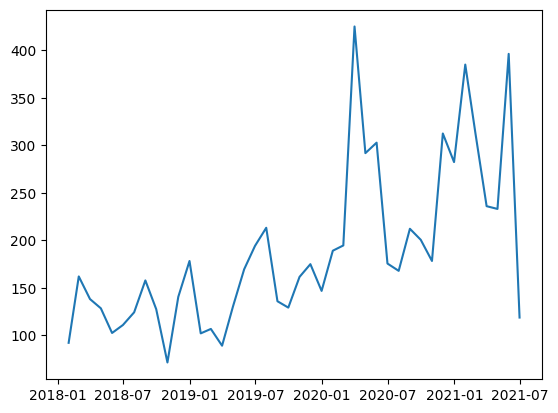

In [ ]:
resampled_data1 = df_5min['exp_OC/V'].resample('D').mean()  # Change 'H' to your desired frequency

plt.figure(figsize=(15, 6))
plt.plot(resampled_data1.index, resampled_data1)
plt.show()

In [ ]:
new_df = df_5min[['close', 'open', 'high', 'low', 'volume']]


In [ ]:
new_df

,close,open,high,low,volume
Date,,,,,
2018-01-01 05:30:00,13600.00,13715.65,13715.65,13576.28,33.617798
2018-01-01 05:35:00,13554.58,13600.00,13600.00,13501.01,40.528679
2018-01-01 05:40:00,13556.15,13554.58,13569.97,13400.01,49.469536
2018-01-01 05:45:00,13430.52,13533.75,13547.73,13402.00,32.725614
2018-01-01 05:50:00,13439.94,13440.01,13459.99,13410.44,26.614135
...,...,...,...,...,...
2021-05-31 23:40:00,36759.67,36849.04,36878.94,36750.46,221.044999
2021-05-31 23:45:00,36801.92,36759.89,36835.99,36730.00,187.001455
2021-05-31 23:50:00,36774.13,36801.93,36874.39,36677.37,271.955089


In [ ]:
import ta

# Assuming df_5min is your DataFrame with columns: 'open', 'high', 'low', 'close', 'volume'

# Calculate RSI
df_5min['rsi'] = ta.momentum.rsi(df_5min['close'], window=14)

# Calculate Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(df_5min['high'], df_5min['low'], df_5min['close'], window=14, smooth_window=3)
df_5min['stoch_%k'] = stoch.stoch()
df_5min['stoch_%d'] = stoch.stoch_signal()

# Calculate Williams %R
df_5min['williams_%r'] = ta.momentum.WilliamsRIndicator(df_5min['high'], df_5min['low'], df_5min['close'], lbp=14).williams_r()

# Calculate MACD
macd = ta.trend.MACD(df_5min['close'])
df_5min['macd_diff'] = macd.macd_diff()

# Calculate OBV
df_5min['obv'] = ta.volume.on_balance_volume(df_5min['close'], df_5min['volume'])


In [ ]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6abaeb06ba92b1ccc65d95c7a43bf364adccc613ca2d2692ee2ea48fca603ec9
  Stored in directory: /Users/alaukikvarma/Library/Caches/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


In [ ]:
df_5min['future_close'] = df_5min['close'].shift(-1)
df_5min.dropna(inplace=True)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Selecting features and target for regression
X = df_5min[['open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_%k', 'stoch_%d', 'williams_%r', 'macd_diff', 'obv']]
y = df_5min['future_close']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Training the regression model
rf_regressor = RandomForestRegressor(n_estimators=30)  # Using 30 trees
rf_regressor.fit(X_train, y_train)


In [ ]:
df_test

,predicted_future_close
0,9203.510667
1,9191.273333
2,9189.516333
3,9200.087000
4,9199.962667
...,...
107098,16971.414333
107099,16965.213000
107100,16965.213000
107101,16965.213000


In [ ]:
combined_df = pd.concat([X_test.reset_index(drop=True), df_test.reset_index(drop=True)], axis=1)



In [ ]:
combined_df

,Date,open,high,low,close,volume,rsi,stoch_%k,stoch_%d,williams_%r,macd_diff,obv,predicted_future_close
0,2020-05-24 06:30:00,9196.38,9208.82,9194.96,9199.00,80.328479,54.092049,85.750301,86.623552,-14.249699,5.327700,-711592.728944,9203.510667
1,2020-05-24 06:35:00,9198.99,9199.00,9185.93,9189.95,55.285115,50.023243,75.830319,81.486353,-24.169681,4.437876,-711648.014059,9191.273333
2,2020-05-24 06:40:00,9191.90,9204.51,9188.85,9190.30,66.228594,50.179323,76.213965,79.264862,-23.786035,3.719753,-711581.785465,9189.516333
3,2020-05-24 06:45:00,9190.31,9202.87,9188.99,9201.99,69.008819,55.210677,87.954272,79.999519,-12.045728,3.862107,-711512.776646,9200.087000
4,2020-05-24 06:50:00,9201.99,9203.00,9196.44,9201.99,73.553418,55.210677,83.891213,82.686483,-16.108787,3.781498,-711439.223228,9199.962667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107098,2021-05-31 23:25:00,36884.67,36949.80,36860.00,36934.73,152.318901,50.667257,48.520183,39.265600,-51.479817,-18.010556,-694179.837954,16971.414333
107099,2021-05-31 23:30:00,36935.81,36955.02,36805.73,36890.24,190.291204,48.496406,42.957900,43.567818,-57.042100,-12.865688,-694370.129158,16965.213000
107100,2021-05-31 23:35:00,36890.85,36893.32,36800.40,36849.03,144.079780,46.508659,34.793462,42.090515,-65.206538,-11.468517,-694514.208938,16965.213000
107101,2021-05-31 23:40:00,36849.04,36878.94,36750.46,36759.67,221.044999,42.445972,22.485207,33.412190,-77.514793,-15.540254,-694735.253937,16965.213000


In [ ]:
import numpy as np

# Initialize the signal column with zeros and a boolean to track trade status
combined_df['signal'] = 0
in_trade = False  # Flag to track if currently in a trade
threshold = 0.01  # Example threshold, e.g., 1%

for i in range(1, len(combined_df)):
    # Check if currently not in a trade
    if not in_trade:
        # Enter trade if predicted future close is higher by the threshold
        if combined_df['predicted_future_close'].iloc[i] > combined_df['close'].iloc[i-1] * (1 + threshold):
            combined_df['signal'].iloc[i] = 1
            in_trade = True  # Update status as in a trade
    else:
        # Exit trade if predicted future close is lower by the threshold
        if combined_df['predicted_future_close'].iloc[i] < combined_df['close'].iloc[i-1] * (1 - threshold):
            combined_df['signal'].iloc[i] = -1
            in_trade = False  # Update status as not in a trade

# Ensure the first signal is 0 (no trade)
combined_df['signal'].iloc[0] = 0


/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/546551203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['signal'].iloc[i] = 1
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/546551203.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['signal'].iloc[i] = -1
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/546551203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [ ]:
trade_log = combined_df[['open', 'high', 'low', 'close', 'volume','signal']]


In [ ]:
trade_log.to_csv('trade_log.csv')

In [277]:

df_5min['fpc'] = (df_5min['close'].shift(-1) - df_5min['close'])/df_5min['close']

window_sizes = range(5, 101)  # For example, from 5 to 100

pearson_correlations = {}
spearman_correlations = {}
kendall_correlations = {}

for window in window_sizes:
    df_5min[f'sma_{window}'] = df_5min['close'].rolling(window=window).mean()
    df_5min[f'sma_change_{window}'] = df_5min[f'sma_{window}'].diff()

    pearson_correlation = df_5min[f'sma_change_{window}'].corr(df_5min['fpc'], method='pearson')
    spearman_correlation = df_5min[f'sma_change_{window}'].corr(df_5min['fpc'], method='spearman')
    kendall_correlation = df_5min[f'sma_change_{window}'].corr(df_5min['fpc'], method='kendall')

    pearson_correlations[window] = pearson_correlation
    spearman_correlations[window] = spearman_correlation
    kendall_correlations[window] = kendall_correlation

    df_5min[f'signal_sma_{window}'] = df_5min.apply(lambda row: 1 if row['close'] > row[f'sma_{window}'] else -1, axis=1)
    df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)

    df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_sma_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)



/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/1032616533.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/1032616533.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_sma_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipyk

In [278]:
# Find the optimal window size for each correlation method
optimal_window_pearson = max(pearson_correlations, key=lambda x: abs(pearson_correlations[x]))
optimal_window_spearman = max(spearman_correlations, key=lambda x: abs(spearman_correlations[x]))
optimal_window_kendall = max(kendall_correlations, key=lambda x: abs(kendall_correlations[x]))

# Print the results
print(f"Optimal SMA window size for Pearson: {optimal_window_pearson}, Maximum Correlation: {pearson_correlations[optimal_window_pearson]}")
print(f"Optimal SMA window size for Spearman: {optimal_window_spearman}, Maximum Correlation: {spearman_correlations[optimal_window_spearman]}")
print(f"Optimal SMA window size for Kendall: {optimal_window_kendall}, Maximum Correlation: {kendall_correlations[optimal_window_kendall]}")

# Calculate overall accuracy for each optimal window size
accuracy_pearson = df_5min[f'accuracy_{optimal_window_pearson}'].mean()
accuracy_spearman = df_5min[f'accuracy_{optimal_window_spearman}'].mean()
accuracy_kendall = df_5min[f'accuracy_{optimal_window_kendall}'].mean()

# Print accuracies
print(f"Accuracy for Pearson optimal window: {accuracy_pearson}")
print(f"Accuracy for Spearman optimal window: {accuracy_spearman}")
print(f"Accuracy for Kendall optimal window: {accuracy_kendall}")

Optimal SMA window size for Pearson: 6, Maximum Correlation: -0.036717361650405456
Optimal SMA window size for Spearman: 5, Maximum Correlation: -0.06822263959884506
Optimal SMA window size for Kendall: 5, Maximum Correlation: -0.05081564365577919
Accuracy for Pearson optimal window: 0.46991223703272794
Accuracy for Spearman optimal window: 0.470267428136729
Accuracy for Kendall optimal window: 0.470267428136729


In [ ]:
window_sizes = range(5, 101)  

pearson_correlations = {}
spearman_correlations = {}
kendall_correlations = {}

for window in window_sizes:
    df_5min[f'ema_{window}'] = df_5min['close'].ewm(span=window, adjust=False).mean()
    df_5min[f'ema_change_{window}'] = df_5min[f'ema_{window}'].diff()

    pearson_correlation = df_5min[f'ema_change_{window}'].corr(df_5min['fpc'], method='pearson')
    spearman_correlation = df_5min[f'ema_change_{window}'].corr(df_5min['fpc'], method='spearman')
    kendall_correlation = df_5min[f'ema_change_{window}'].corr(df_5min['fpc'], method='kendall')

    pearson_correlations[window] = pearson_correlation
    spearman_correlations[window] = spearman_correlation
    kendall_correlations[window] = kendall_correlation

    df_5min[f'signal_ema_{window}'] = df_5min.apply(lambda row: 1 if row['close'] > row[f'ema_{window}'] else -1, axis=1)
    df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)

    df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_ema_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)

In [280]:
# Find the optimal window size for each correlation method
optimal_window_pearson = max(pearson_correlations, key=lambda x: abs(pearson_correlations[x]))
optimal_window_spearman = max(spearman_correlations, key=lambda x: abs(spearman_correlations[x]))
optimal_window_kendall = max(kendall_correlations, key=lambda x: abs(kendall_correlations[x]))

# Print the results
print(f"Optimal EMA window size for Pearson: {optimal_window_pearson}, Maximum Correlation: {pearson_correlations[optimal_window_pearson]}")
print(f"Optimal EMA window size for Spearman: {optimal_window_spearman}, Maximum Correlation: {spearman_correlations[optimal_window_spearman]}")
print(f"Optimal EMA window size for Kendall: {optimal_window_kendall}, Maximum Correlation: {kendall_correlations[optimal_window_kendall]}")

# Calculate overall accuracy for each optimal window size
accuracy_pearson = df_5min[f'accuracy_{optimal_window_pearson}'].mean()
accuracy_spearman = df_5min[f'accuracy_{optimal_window_spearman}'].mean()
accuracy_kendall = df_5min[f'accuracy_{optimal_window_kendall}'].mean()

# Print accuracies
print(f"Accuracy for Pearson optimal window: {accuracy_pearson}")
print(f"Accuracy for Spearman optimal window: {accuracy_spearman}")
print(f"Accuracy for Kendall optimal window: {accuracy_kendall}")


Optimal EMA window size for Pearson: 7, Maximum Correlation: -0.033960092177000994
Optimal EMA window size for Spearman: 5, Maximum Correlation: -0.07900289360658162
Optimal EMA window size for Kendall: 5, Maximum Correlation: -0.05891183261912982
Accuracy for Pearson optimal window: 0.4673308087729406
Accuracy for Spearman optimal window: 0.4676412513913982
Accuracy for Kendall optimal window: 0.4676412513913982


In [ ]:
# Assuming df_5min is a predefined DataFrame with a 'close' column
# The 'close' column would need to have numeric data for the following operations to work

# Define a function to calculate TEMA (Triple Exponential Moving Average)
def TEMA(df, window):
    ema1 = df.ewm(span=window, adjust=False).mean()
    ema2 = ema1.ewm(span=window, adjust=False).mean()
    ema3 = ema2.ewm(span=window, adjust=False).mean()
    return 3 * (ema1 - ema2) + ema3

# Calculate future price change (fpc)
df_5min['fpc'] = (df_5min['close'].shift(-1) - df_5min['close'])/df_5min['close']

window_sizes = range(5, 101)  # From 5 to 100

# Dictionaries to store correlations for each window size
pearson_correlations = {}
spearman_correlations = {}
kendall_correlations = {}

for window in window_sizes:
    # Calculate TEMA for each window
    df_5min[f'tema_{window}'] = TEMA(df_5min['close'], window)
    df_5min[f'tema_change_{window}'] = df_5min[f'tema_{window}'].diff()

    # Calculate correlations
    pearson_correlation = df_5min[f'tema_change_{window}'].corr(df_5min['fpc'], method='pearson')
    spearman_correlation = df_5min[f'tema_change_{window}'].corr(df_5min['fpc'], method='spearman')
    kendall_correlation = df_5min[f'tema_change_{window}'].corr(df_5min['fpc'], method='kendall')

    pearson_correlations[window] = pearson_correlation
    spearman_correlations[window] = spearman_correlation
    kendall_correlations[window] = kendall_correlation

    # Generate trading signals based on TEMA
    df_5min[f'signal_tema_{window}'] = df_5min.apply(lambda row: 1 if row['close'] > row[f'tema_{window}'] else -1, axis=1)
    df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)

    # Calculate accuracy
    df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_tema_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)





In [ ]:
# Find the optimal window size for each correlation method
optimal_window_pearson = max(pearson_correlations, key=lambda x: abs(pearson_correlations[x]))
optimal_window_spearman = max(spearman_correlations, key=lambda x: abs(spearman_correlations[x]))
optimal_window_kendall = max(kendall_correlations, key=lambda x: abs(kendall_correlations[x]))

# Calculate overall accuracy for each optimal window size
accuracy_pearson = df_5min[f'accuracy_{optimal_window_pearson}'].mean()
accuracy_spearman = df_5min[f'accuracy_{optimal_window_spearman}'].mean()
accuracy_kendall = df_5min[f'accuracy_{optimal_window_kendall}'].mean()

# Print the results
print(f"Optimal TEMA window size for Pearson: {optimal_window_pearson}, Maximum Correlation: {pearson_correlations[optimal_window_pearson]}")
print(f"Optimal TEMA window size for Spearman: {optimal_window_spearman}, Maximum Correlation: {spearman_correlations[optimal_window_spearman]}")
print(f"Optimal TEMA window size for Kendall: {optimal_window_kendall}, Maximum Correlation: {kendall_correlations[optimal_window_kendall]}")
print(f"Accuracy for Pearson optimal window: {accuracy_pearson}")
print(f"Accuracy for Spearman optimal window: {accuracy_spearman}")
print(f"Accuracy for Kendall optimal window: {accuracy_kendall}")

In [282]:
# Assuming df_5min is a predefined DataFrame with a 'close' column
# The 'close' column would need to have numeric data for the following operations to work

# First, we need to define a function to calculate DEMA as it is not a built-in function in pandas

def DEMA(df, window):
    ema = df.ewm(span=window, adjust=False).mean()
    dema = 2 * ema - ema.ewm(span=window, adjust=False).mean()
    return dema

# Calculate future price change (fpc)
df_5min['fpc'] = (df_5min['close'].shift(-1) - df_5min['close'])/df_5min['close']

window_sizes = range(5, 101)  # From 5 to 100

# Dictionaries to store correlations for each window size
pearson_correlations = {}
spearman_correlations = {}
kendall_correlations = {}

for window in window_sizes:
    # Calculate DEMA for each window
    df_5min[f'dema_{window}'] = DEMA(df_5min['close'], window)
    df_5min[f'dema_change_{window}'] = df_5min[f'dema_{window}'].diff()

    # Calculate correlations
    pearson_correlation = df_5min[f'dema_change_{window}'].corr(df_5min['fpc'], method='pearson')
    spearman_correlation = df_5min[f'dema_change_{window}'].corr(df_5min['fpc'], method='spearman')
    kendall_correlation = df_5min[f'dema_change_{window}'].corr(df_5min['fpc'], method='kendall')

    pearson_correlations[window] = pearson_correlation
    spearman_correlations[window] = spearman_correlation
    kendall_correlations[window] = kendall_correlation

    # Generate trading signals based on DEMA
    df_5min[f'signal_dema_{window}'] = df_5min.apply(lambda row: 1 if row['close'] > row[f'dema_{window}'] else -1, axis=1)
    df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)

    # Calculate accuracy
    df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_dema_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)

# Find the optimal window size for each correlation method
optimal_window_pearson = max(pearson_correlations, key=lambda x: abs(pearson_correlations[x]))
optimal_window_spearman = max(spearman_correlations, key=lambda x: abs(spearman_correlations[x]))
optimal_window_kendall = max(kendall_correlations, key=lambda x: abs(kendall_correlations[x]))

# Calculate overall accuracy for each optimal window size
accuracy_pearson = df_5min[f'accuracy_{optimal_window_pearson}'].mean()
accuracy_spearman = df_5min[f'accuracy_{optimal_window_spearman}'].mean()
accuracy_kendall = df_5min[f'accuracy_{optimal_window_kendall}'].mean()

# Print the results
print(f"Optimal DEMA window size for Pearson: {optimal_window_pearson}, Maximum Correlation: {pearson_correlations[optimal_window_pearson]}")
print(f"Optimal DEMA window size for Spearman: {optimal_window_spearman}, Maximum Correlation: {spearman_correlations[optimal_window_spearman]}")
print(f"Optimal DEMA window size for Kendall: {optimal_window_kendall}, Maximum Correlation: {kendall_correlations[optimal_window_kendall]}")
print(f"Accuracy for Pearson optimal window: {accuracy_pearson}")
print(f"Accuracy for Spearman optimal window: {accuracy_spearman}")
print(f"Accuracy for Kendall optimal window: {accuracy_kendall}")



/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/2685892887.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5min[f'dema_{window}'] = DEMA(df_5min['close'], window)
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/2685892887.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5min[f'dema_change_{window}'] = df_5min[f'dema_{window}'].diff()
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/2685892887.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usual

Optimal DEMA window size for Pearson: 13, Maximum Correlation: -0.033360926041771
Optimal DEMA window size for Spearman: 6, Maximum Correlation: -0.07714992972266142
Optimal DEMA window size for Kendall: 7, Maximum Correlation: -0.05727551802557117
Accuracy for Pearson optimal window: 0.4746639668413722
Accuracy for Spearman optimal window: 0.4776257572282788
Accuracy for Kendall optimal window: 0.4768902039971585


In [283]:
# Assuming df_5min is a predefined DataFrame with a 'close' column
# The 'close' column would need to have numeric data for the following operations to work

# Calculate future price change (fpc)
df_5min['fpc'] = (df_5min['close'].shift(-1) - df_5min['close'])/df_5min['close']

window_sizes = range(5, 101)  # From 5 to 100

# Dictionaries to store correlations for each window size
pearson_correlations = {}
spearman_correlations = {}
kendall_correlations = {}

# Function to calculate Weighted Moving Average (WMA)
def calculate_wma(data, window):
    weights = np.arange(1, window + 1)
    return data.rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

for window in window_sizes:
    # Calculate WMA for each window
    df_5min[f'wma_{window}'] = calculate_wma(df_5min['close'], window)
    df_5min[f'wma_change_{window}'] = df_5min[f'wma_{window}'].diff()

    # Calculate correlations
    pearson_correlation = df_5min[f'wma_change_{window}'].corr(df_5min['fpc'], method='pearson')
    spearman_correlation = df_5min[f'wma_change_{window}'].corr(df_5min['fpc'], method='spearman')
    kendall_correlation = df_5min[f'wma_change_{window}'].corr(df_5min['fpc'], method='kendall')

    pearson_correlations[window] = pearson_correlation
    spearman_correlations[window] = spearman_correlation
    kendall_correlations[window] = kendall_correlation

    # Generate trading signals based on WMA
    df_5min[f'signal_wma_{window}'] = df_5min.apply(lambda row: 1 if row['close'] > row[f'wma_{window}'] else -1, axis=1)
    df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)

    # Calculate accuracy
    df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_wma_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)

# Find the optimal window size for each correlation method
optimal_window_pearson = max(pearson_correlations, key=lambda x: abs(pearson_correlations[x]))
optimal_window_spearman = max(spearman_correlations, key=lambda x: abs(spearman_correlations[x]))
optimal_window_kendall = max(kendall_correlations, key=lambda x: abs(kendall_correlations[x]))

# Calculate overall accuracy for each optimal window size
accuracy_pearson = df_5min[f'accuracy_{optimal_window_pearson}'].mean()
accuracy_spearman = df_5min[f'accuracy_{optimal_window_spearman}'].mean()
accuracy_kendall = df_5min[f'accuracy_{optimal_window_kendall}'].mean()

# Print the results
print(f"Optimal WMA window size for Pearson: {optimal_window_pearson}, Maximum Correlation: {pearson_correlations[optimal_window_pearson]}")
print(f"Optimal WMA window size for Spearman: {optimal_window_spearman}, Maximum Correlation: {spearman_correlations[optimal_window_spearman]}")
print(f"Optimal WMA window size for Kendall: {optimal_window_kendall}, Maximum Correlation: {kendall_correlations[optimal_window_kendall]}")

print(f"Accuracy for Pearson optimal window: {accuracy_pearson}")
print(f"Accuracy for Spearman optimal window: {accuracy_spearman}")
print(f"Accuracy for Kendall optimal window: {accuracy_kendall}")



/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/496961279.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5min[f'wma_{window}'] = calculate_wma(df_5min['close'], window)
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/496961279.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5min[f'wma_change_{window}'] = df_5min[f'wma_{window}'].diff()
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/496961279.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is us

Optimal WMA window size for Pearson: 7, Maximum Correlation: -0.033227455015108785
Optimal WMA window size for Spearman: 6, Maximum Correlation: -0.0749794783476082
Optimal WMA window size for Kendall: 6, Maximum Correlation: -0.05588738514381994
Accuracy for Pearson optimal window: 0.46886624118314996
Accuracy for Spearman optimal window: 0.468782337772756
Accuracy for Kendall optimal window: 0.468782337772756


In [284]:
# Assuming df_5min is a predefined DataFrame with a 'close' column
# The 'close' column would need to have numeric data for the following operations to work

# Define a function to calculate KAMA (Kaufman Adaptive Moving Average)
def KAMA(df, window, fast=2, slow=30):
    # Efficiency Ratio (ER)
    change = df['close'].diff(periods=window).abs()
    volatility = df['close'].diff().abs().rolling(window=window).sum()
    er = change / volatility

    # Smoothing Constant (SC)
    sc = ((er * (2 / (fast + 1) - 2 / (slow + 1)) + 2 / (slow + 1)) ** 2).fillna(0)

    # KAMA
    kama = pd.Series(index=df.index)
    kama.iloc[:window] = df['close'].iloc[:window].mean()
    for i in range(window, len(df)):
        kama.iloc[i] = kama.iloc[i-1] + sc.iloc[i] * (df['close'].iloc[i] - kama.iloc[i-1])

    return kama

# Calculate future price change (fpc)
df_5min['fpc'] = (df_5min['close'].shift(-1) - df_5min['close'])/df_5min['close']

window_sizes = range(5, 101)  # From 5 to 100

# Dictionaries to store correlations for each window size
pearson_correlations = {}
spearman_correlations = {}
kendall_correlations = {}

for window in window_sizes:
    # Calculate KAMA for each window
    df_5min[f'kama_{window}'] = KAMA(df_5min, window)
    df_5min[f'kama_change_{window}'] = df_5min[f'kama_{window}'].diff()

    # Calculate correlations
    pearson_correlation = df_5min[f'kama_change_{window}'].corr(df_5min['fpc'], method='pearson')
    spearman_correlation = df_5min[f'kama_change_{window}'].corr(df_5min['fpc'], method='spearman')
    kendall_correlation = df_5min[f'kama_change_{window}'].corr(df_5min['fpc'], method='kendall')

    pearson_correlations[window] = pearson_correlation
    spearman_correlations[window] = spearman_correlation
    kendall_correlations[window] = kendall_correlation

    # Generate trading signals based on KAMA
    df_5min[f'signal_kama_{window}'] = df_5min.apply(lambda row: 1 if row['close'] > row[f'kama_{window}'] else -1, axis=1)
    df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)

    # Calculate accuracy
    df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_kama_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)

# Find the optimal window size for each correlation method
optimal_window_pearson = max(pearson_correlations, key=lambda x: abs(pearson_correlations[x]))
optimal_window_spearman = max(spearman_correlations, key=lambda x: abs(spearman_correlations[x]))
optimal_window_kendall = max(kendall_correlations, key=lambda x: abs(kendall_correlations[x]))

# Calculate overall accuracy for each optimal window size
accuracy_pearson = df_5min[f'accuracy_{optimal_window_pearson}'].mean()
accuracy_spearman = df_5min[f'accuracy_{optimal_window_spearman}'].mean()
accuracy_kendall = df_5min[f'accuracy_{optimal_window_kendall}'].mean()

# Print the results
print(f"Optimal KAMA window size for Pearson: {optimal_window_pearson}, Maximum Correlation: {pearson_correlations[optimal_window_pearson]}")
print(f"Optimal KAMA window size for Spearman: {optimal_window_spearman}, Maximum Correlation: {spearman_correlations[optimal_window_spearman]}")
print(f"Optimal KAMA window size for Kendall: {optimal_window_kendall}, Maximum Correlation: {kendall_correlations[optimal_window_kendall]}")
print(f"Accuracy for Pearson optimal window: {accuracy_pearson}")
print(f"Accuracy for Kendall optimal window: {accuracy_kendall}")
print(f"Accuracy for Spearman optimal window: {accuracy_spearman}")



/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/3555697044.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5min[f'kama_{window}'] = KAMA(df_5min, window)
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/3555697044.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5min[f'kama_change_{window}'] = df_5min[f'kama_{window}'].diff()
/var/folders/gx/tnh165z514x8q_bkbj3sbvwm0000gn/T/ipykernel_41473/3555697044.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

KeyboardInterrupt: 

In [ ]:
# Assuming df_5min is a predefined DataFrame with a 'close' column
# The 'close' column would need to have numeric data for the following operations to work

# Define a function to calculate TRIMA (Triangular Moving Average)
def TRIMA(df, window):
    weights = np.arange(1, window + 1)
    weights = np.concatenate((weights, weights[::-1][1:])) if window % 2 == 0 else np.concatenate((weights, weights[::-1]))
    trima = df.rolling(window * 2 - 1).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return trima

# Calculate future price change (fpc)
df_5min['fpc'] = df_5min['close'].shift(-1) - df_5min['close']

window_sizes = range(5, 101)  # From 5 to 100

# Dictionaries to store correlations for each window size
pearson_correlations = {}
spearman_correlations = {}
kendall_correlations = {}

for window in window_sizes:
    # Calculate TRIMA for each window
    df_5min[f'trima_{window}'] = TRIMA(df_5min['close'], window)
    df_5min[f'trima_change_{window}'] = df_5min[f'trima_{window}'].diff()

    # Calculate correlations
    pearson_correlation = df_5min[f'trima_change_{window}'].corr(df_5min['fpc'], method='pearson')
    spearman_correlation = df_5min[f'trima_change_{window}'].corr(df_5min['fpc'], method='spearman')
    kendall_correlation = df_5min[f'trima_change_{window}'].corr(df_5min['fpc'], method='kendall')

    pearson_correlations[window] = pearson_correlation
    spearman_correlations[window] = spearman_correlation
    kendall_correlations[window] = kendall_correlation

    # Generate trading signals based on TRIMA
    df_5min[f'signal_trima_{window}'] = df_5min.apply(lambda row: 1 if row['close'] > row[f'trima_{window}'] else -1, axis=1)
    df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)

    # Calculate accuracy
    df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_trima_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)

# Find the optimal window size for each correlation method



In [ ]:
optimal_window_pearson = max(pearson_correlations, key=lambda x: abs(pearson_correlations[x]))
optimal_window_spearman = max(spearman_correlations, key=lambda x: abs(spearman_correlations[x]))
optimal_window_kendall = max(kendall_correlations, key=lambda x: abs(kendall_correlations[x]))

# Calculate overall accuracy for each optimal window size
accuracy_pearson = df_5min[f'accuracy_{optimal_window_pearson}'].mean()
accuracy_spearman = df_5min[f'accuracy_{optimal_window_spearman}'].mean()
accuracy_kendall = df_5min[f'accuracy_{optimal_window_kendall}'].mean()

# Print the results
print(f"Optimal TRIMA window size for Pearson: {optimal_window_pearson}, Maximum Correlation: {pearson_correlations[optimal_window_pearson]}")
print(f"Optimal TRIMA window size for Spearman: {optimal_window_spearman}, Maximum Correlation: {spearman_correlations[optimal_window_spearman]}")
print(f"Optimal TRIMA window size for Kendall: {optimal_window_kendall}, Maximum Correlation: {kendall_correlations[optimal_window_kendall]}")
print(f"Accuracy for Pearson optimal window: {accuracy_pearson}")
print(f"Accuracy for Spearman optimal window: {accuracy_spearman}")
print(f"Accuracy for Kendall optimal window: {accuracy_kendall}")

In [ ]:
window_sizes = range(5, 101)  

pearson_correlations = {}
spearman_correlations = {}
kendall_correlations = {}

for window in window_sizes:
    df_5min[f'ema_{window}'] = df_5min['close'].ewm(span=window, adjust=False).mean()
    df_5min[f'ema_change_{window}'] = df_5min[f'ema_{window}'].diff()

    pearson_correlation = df_5min[f'ema_change_{window}'].corr(df_5min['fpc'], method='pearson')
    spearman_correlation = df_5min[f'ema_change_{window}'].corr(df_5min['fpc'], method='spearman')
    kendall_correlation = df_5min[f'ema_change_{window}'].corr(df_5min['fpc'], method='kendall')

    pearson_correlations[window] = pearson_correlation
    spearman_correlations[window] = spearman_correlation
    kendall_correlations[window] = kendall_correlation

    df_5min[f'signal_ema_{window}'] = df_5min.apply(lambda row: 1 if row['close'] > row[f'ema_{window}'] else -1, axis=1)
    df_5min[f'signal_fpc_{window}'] = df_5min['fpc'].apply(lambda x: 1 if x > 0 else -1)

    df_5min[f'accuracy_{window}'] = df_5min.apply(lambda row: 1 if row[f'signal_ema_{window}'] == row[f'signal_fpc_{window}'] else 0, axis=1)